In [1]:
from netCDF4 import Dataset
from collections import defaultdict, namedtuple
import datetime
import numpy as np
import seaborn as sns
sns.set()
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math
import os
import time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import csv
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels

In [2]:
month = '201305'

towmetds = Dataset('data/cabauw/cesar_tower_meteo_lc1_t10_v1.0_%s.nc' % month)
meteods = Dataset('data/cabauw/cesar_surface_meteo_lc1_t10_v1.0_%s.nc' % month)
fluxds = Dataset('data/cabauw/cesar_surface_flux_lc1_t10_v1.0_%s.nc' % month)
soilds = Dataset('data/cabauw/cesar_soil_heat_lb1_t10_v1.0_%s.nc' % month)

The Obukhov length is computed as follows (Hogstrom 1988):

$$
L=-\frac{u_*^3 T_0}{kg\overline{w'\theta_v}}
$$

where $u_*$ is the friction velocity, $T_0$ the surface temperature, $k$ the von Karman constant (approximately 0.4), $\theta_v$ the flux of potential virtual temperature, $g$ the gravitational constant.

We have

$$
\overline{w'\theta_v}=-\frac{H}{\rho_0 c_p}\left(1+0.07\frac{E\lambda}{H}\right)
$$

With $H$ being the turbulent sensible heat flux and $L\lambda$ the turbulent latent heat flux, $\rho$ the air density, $c_p$ the specific heat. The specific heat is a function of temperature, but between 250 and 350 K it takes values between 1003 and 1008 J/kg.K, thus we can assume it constant at 1005.

The air density can be derived using the ideal gas law:

$$
\rho=\frac{P}{RT_0}
$$

with $P$ the surface pressure in Pascal, $T_0$ the surace temperature in Kelvin, and $R$ the specific gas constant. For dry air, $R=287.058$ J/kg.K, and varies slightly depending on the composition of air (e.g. moisture) TODO does it matter?

In [94]:
df[(df.z == 20) & (df.ustar < 0.5)][measurement_cols].describe().T

count         mean         std         min          25%  \
air_dens      466112.0     0.275350    0.120082    0.102647     0.199821   
H             466112.0     5.163648   46.203109 -307.354187   -24.175905   
LE            466112.0    73.225193  116.231848 -534.843600    -7.945070   
ustar         466112.0     0.273520    0.101910    0.100000     0.190113   
wind          466112.0     5.236153    1.904799    1.000159     3.890000   
temp          466112.0   284.760239    6.554482  259.850006   280.049988   
virtual_temp  466112.0  1448.218694  464.202772  152.481552  1097.737457   
soil_temp     391754.0   284.467050    5.711538  271.882630   279.675790   
z             466112.0    20.000000    0.000000   20.000000    20.000000   

                      50%          75%          max  
air_dens         0.253969     0.321992     2.319341  
H              -14.056643    29.182797   479.642334  
LE              18.951317   134.099662  6940.750000  
ustar            0.264469     0.349760     0.499999  
wind             4.990000     6.450000    17.590000  
temp           284.850006   289.549988   306.750000  
virtual_temp  1390.946594  1768.383911  3419.925049  
soil_temp      284.599959   289.201054   302.586436  
z               20.000000    20.000000    20.000000

/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


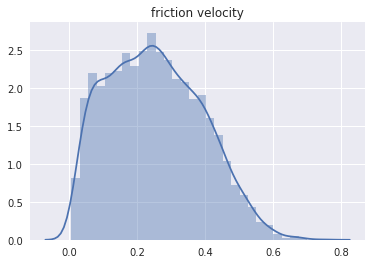

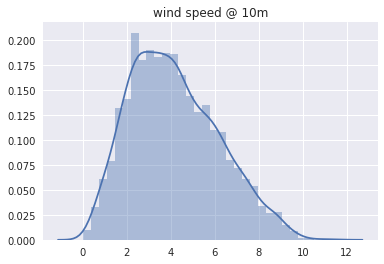

In [7]:
sns.distplot(fluxds['UST'][:])
plt.title('friction velocity')
plt.show()

sns.distplot(towmetds['F'][:, -2])
plt.title('wind speed @ 10m')
plt.show()

In [33]:
class TempVar:
    ''' context manager providing facility for temporary variables in a block
        useful to avoid polluting things with endless temporary variables
    '''
    def __init__(self, **kwargs):
        self.variables = kwargs
        self.old_values = {}

    def __enter__(self):
        glob = globals()
        for k, v in self.variables.items():
            if k in glob:
                self.old_values[k] = glob[k]
            glob[k] = v
        return self.old_values

    def __exit__(self, exc_type, exc_value, traceback):
        glob = globals()
        for k in self.variables:
            if k in self.old_values:
                glob[k] = self.old_values[k]
            else:
                glob.pop(k)

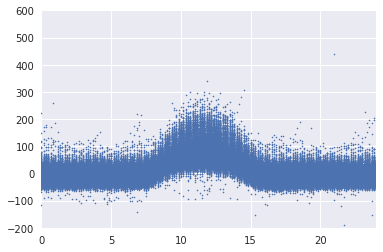

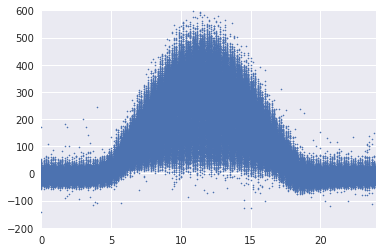

In [183]:
seasons = [
    [11, 12, 1, 2],
    [4, 5, 6, 7, 8],
]

for i, ss in enumerate(seasons):
    with TempVar(df=df[df.month.isin(ss)]):
        plt.scatter(df.tt % 24, df.LE, s=1)
        plt.ylim(-200, 600)
        plt.xlim(0, 24)
        plt.show()

/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


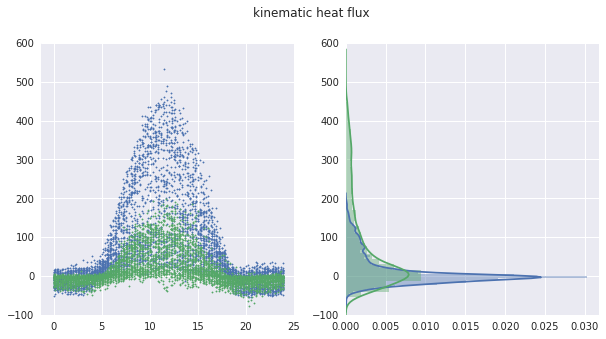

"\nplt.figure(figsize=(10, 5))\nplt.suptitle('potential heat flux')\nplt.subplot(1, 2, 1)\nplt.scatter(fluxds['time'][:] % 24, fluxds['LE'][:], s=2)\nplt.ylim(-100, 600)\nplt.subplot(1, 2, 2)\nsns.distplot(fluxds['LE'][:], vertical=True)\nplt.ylim(-100, 600)\nplt.show()\n"

In [47]:
plt.figure(figsize=(10, 5))
plt.suptitle('kinematic heat flux')
plt.subplot(1, 2, 1)
plt.scatter(fluxds['time'][:] % 24, fluxds['LE'][:], s=2)
plt.scatter(fluxds['time'][:] % 24, fluxds['H'][:], s=2)
plt.ylim(-100, 600)
plt.subplot(1, 2, 2)
sns.distplot(fluxds['H'][:], vertical=True)
sns.distplot(fluxds['LE'][:], vertical=True)
plt.ylim(-100, 600)
plt.show()

'''
plt.figure(figsize=(10, 5))
plt.suptitle('potential heat flux')
plt.subplot(1, 2, 1)
plt.scatter(fluxds['time'][:] % 24, fluxds['LE'][:], s=2)
plt.ylim(-100, 600)
plt.subplot(1, 2, 2)
sns.distplot(fluxds['LE'][:], vertical=True)
plt.ylim(-100, 600)
plt.show()
'''

/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


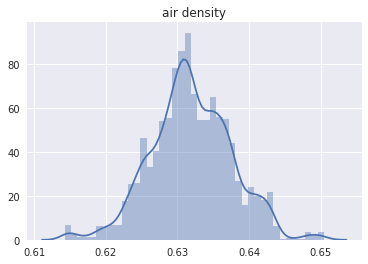

In [9]:
air_density = 100 * meteods['P0'][:] / (287.058 * (273.15 + meteods['TA002'][:]))

sns.distplot(air_density)
plt.title('air density')
plt.show()

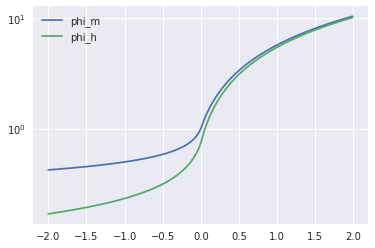

In [10]:
def phi_m(zL):
    if zL < 0:
        return math.pow(1 - 15 * zL, -0.25)
    else:
        return 1 + 4.7 * zL

    
def phi_h(zL):
    if zL < 0:
        return 0.74 * math.pow(1 - 9 * zL, -0.5)
    else:
        return 0.74 + 4.7 * zL


xx = np.arange(-2, 2, 0.01)
ym = list(map(phi_m, xx))
yh = list(map(phi_h, xx))
plt.plot(xx, ym, label='phi_m')
plt.plot(xx, yh, label='phi_h')
plt.yscale('log')
plt.legend()
plt.show()

## computing profiles

### polynomial/spline interpolation

C:\Users\edo\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  


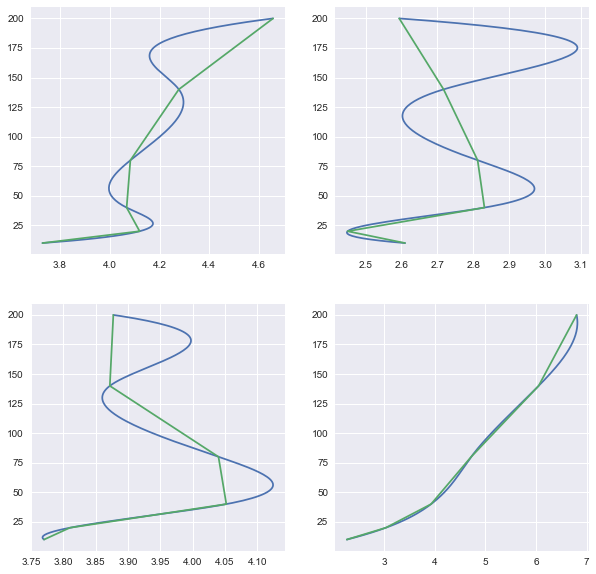

In [20]:
from scipy.interpolate import spline

zi = np.arange(10, 201, 1)

plt.figure(figsize=(10, 10))
for i, tt in enumerate([44, 351, 631, 551]):
    
    wi = spline(towmetds['z'][:6][::-1], towmetds['F'][tt][:-1][::-1], zi, order=3)

    plt.subplot(2, 2, i + 1)
    plt.plot(wi, zi)
    plt.plot(towmetds['F'][tt][:-1], towmetds['z'][:6])

plt.show()

not a good option: the curves are too wiggly. the problem is that the spline passes exactly through all points, and does not allow noise

### non-parametric regression

for wind, we can try gaussian processes with the kernel

$$
k(z_1,z_2)
=\exp\left(-\frac{(z_1-z_2)^2}{2\sigma_0^2}\right)
+\sqrt{\sigma_1^2 z_1 z_2}
+k
+\sigma_2^2\mathbb{1}[z_1=z_2]
$$

with $\sigma_2=0.1 m/s$ coming from the instruments's specifications. have to check the right value for the temperature

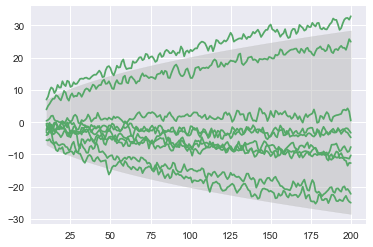

In [21]:
kernel = (
    kernels.RBF()
    + kernels.ConstantKernel()
    + kernels.Exponentiation(kernels.DotProduct(), 0.5)
   # + kernels.WhiteKernel()
)

gpr = GaussianProcessRegressor(kernel, normalize_y=True, alpha=0.01)

prior_mean, prior_std = gpr.predict(zi.reshape(-1, 1), return_std=True)
samples = gpr.sample_y(zi.reshape(-1, 1), n_samples=10)

plt.fill_between(zi, prior_mean - 2 * prior_std, prior_mean + 2 * prior_std,
                 color='#bbbbbb', alpha=0.5)

for ss in samples.T:
    plt.plot(zi, ss, 'C1-')

plt.show()

In [22]:
list(sorted([(tt, max(towmetds['F'][tt][:-1])) for tt in range(len(towmetds['time'][:]))], key=lambda x: x[1]))[-4:]

[(1566, 16.751036), (3917, 16.792416), (3916, 16.798523), (3918, 17.026247)]

C:\Users\edo\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([2.47928479e-04, 2.38997412e-02, 2.90886992e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 76, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\edo\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.04137866e-04,  6.35065813e-06,  3.34276815e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)


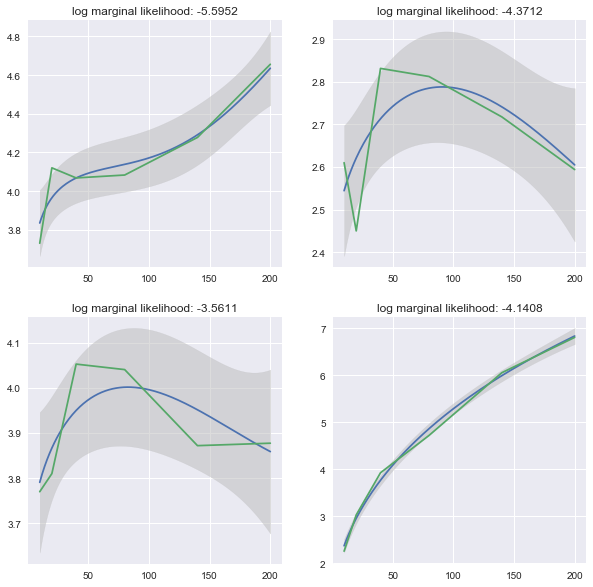

In [23]:
plt.figure(figsize=(10, 10))
for i, tt in enumerate([44, 351, 631, 551]):
    alt, measure, noise = towmetds['z'][:6], towmetds['F'][tt][:-1], 0.1
    #alt, measure, noise = towmetds['z'][:], towmetds['TA'][tt][:], 0.5
    
    gpr = GaussianProcessRegressor(
        kernel, n_restarts_optimizer=50, normalize_y=False,
        alpha=noise**2
    ).fit(
        alt.reshape(-1, 1), measure
    )
    wi, std = gpr.predict(zi.reshape(-1, 1), return_std=True)

    plt.subplot(2, 2, i + 1)
    plt.title('log marginal likelihood: %.4f' % gpr.log_marginal_likelihood())
    plt.fill_between(zi, wi - 2 * std, wi + 2 * std, color='#bbbbbb', alpha=0.5)
    plt.plot(zi, wi)
    plt.plot(alt, measure)

plt.show()

In [24]:
def kernel(z1, z2):
    # returns value, derivative wrt z1

    params = gpr.kernel_.get_params()
    sigma_0 = params['k1__k1__length_scale']
    sigma_1 = params['k2__kernel__sigma_0']
    k = params['k1__k2__constant_value']
    
    ker = k + np.exp(-(z1-z2)**2/(2*sigma_0**2))+np.sqrt(sigma_1**2+z1*z2)
    der = (
        (z2 - z1)/(sigma_0**2) * np.exp(-(z1-z2)**2/(2*sigma_0**2))
        + z2 / (2 * np.sqrt(sigma_1**2 + z1*z2))
    )

    return ker, der

kernel(10, 20)

(15.141953753119328, 0.7072368501804365)

In [161]:
gpr.kernel_([[10], [20]])

array([[11.00029204, 15.14173897],
       [15.14173897, 21.00026076]])

In [148]:
gpr.predict(zp)

array([4.08501024, 5.28527787, 6.14441531])

In [157]:
eps = 1e-5
(gpr.predict(zp + eps) - gpr.predict(zp - eps)) / (2 * eps)

array([0.02996775, 0.01972772, 0.01512288])

In [150]:
kp = np.array([
    kernel(z1, z2)[1][0]
    for z1 in zp for z2 in zz
]).reshape((len(zp), len(zz)))

kp.dot(alpha)

masked_array(data=[0.02996776, 0.01972771, 0.01512285],
             mask=False,
       fill_value=-9999.0)

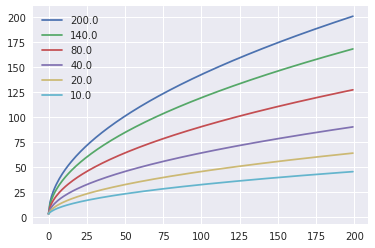

In [66]:
xx = np.arange(0, 200, 1)
kvals = gpr.kernel_(towmetds['z'][:6].reshape(-1, 1), xx.reshape(-1, 1))
for z, k in zip(towmetds['z'][:6], kvals):
    plt.plot(xx, k, label=str(z))
plt.legend()

result is pretty cool actually. sometimes the function looks too smooth (top right plot), but considering that the values differ by 0.1/0.2, that might very well be explained by noise in the measurement. the problem is that it takes *ages* to fit

In [61]:
def gpmodel(zs, ys, noise, zpred=None):
    zpred = zpred if zpred is not None else zs

    kernel = (
        kernels.RBF()
        + kernels.ConstantKernel()
        + kernels.Exponentiation(kernels.DotProduct(), 0.5)
       # + kernels.WhiteKernel()
    )


    (zs, ys), good_data = prepare_arrays(zs, ys)

    gpr = GaussianProcessRegressor(
        kernel, n_restarts_optimizer=50, normalize_y=True,
        alpha=noise**2,
    ).fit(
        zs.reshape(-1, 1), ys
    )

    eps = 0.01
    preds = gpr.predict(np.array([
        (z - eps, z, z + eps)
        for z in zpred.reshape(-1, 1)
    ]).reshape(-1, 1))

    pp = preds[1::3]
    dydz = (preds[2::3] - preds[0::3]) / (2 * eps)

    return pp, dydz

### finite differences

aka difference quotient, obtained by averaging top and bottom derivatives (quantity is $x$ and altitude is $y$)

$$
f^\prime(z)=\frac{1}{2}\cdot\left(
\frac{y_{i+1}-y_i}{z_{i+1}-z_i}+\frac{y_i-y_{i-1}}{z_i-z_{i-1}}
\right)
$$

for boundary values we can only use the previous/next measurement

$$
\frac{\partial x_0}{\partial y_0}=\frac{x_1-x_0}{y_1-y_0}
$$

~~we fill missing values with linear interpolation. this will result in the same gradient, but at least we won't throw away the value~~

we cannot use linear interpolation to fill the value, because the wind profile is not linear, and cannot be approximated like that. instead, we simply skip the value

In [62]:
ProfileData = namedtuple('ProfileData', ['z', 'measure', 'model', 'derivative'])


def prepare_arrays(*arrs):
    # replace masked values with nans
    # then remove element at position i from all arrays
    # if any of them is nan/inf
    # returns cleaned arrays and mask
    mask = np.logical_and(*[
        np.isfinite(np.ma.filled(a, np.nan))
        for a in arrs
    ])

    return [np.array(a)[mask] for a in arrs], mask


def get_derivative(xs, ys):
    # returns dydx by weighted finite differences
    # nans/infs/masked values are skipped in the computation,
    # but preserved in the output (all replaced with nans)
    
    (gxs, gys), good_data = prepare_arrays(xs, ys)

    # compute derivative with good measurements
    gdydx = []
    for i in range(len(gxs)):
        if i == 0:
            d = (gys[i] - gys[i + 1]) / (gxs[i] - gxs[i + 1])
        elif i == len(gxs) - 1:
            d = (gys[i - 1] - gys[i]) / (gxs[i - 1] - gxs[i])
        else:
            #d = (gys[i - 1] - gys[i + 1]) / (gxs[i - 1] - gxs[i + 1])
            d = 0.5 * (
                (gys[i + 1] - gys[i]) / (gxs[i + 1] - gxs[i])
                + (gys[i] - gys[i - 1]) / (gxs[i] - gxs[i - 1])
            )

        gdydx.append(d)

    # insert back nans
    dydx = np.zeros(len(xs))
    dydx[good_data] = gdydx
    dydx[~good_data] = np.nan

    return dydx

### logarithmic wind profile

another option is to model the wind as $u(z)=a+bz+cz^2+d\ln z$, with $\partial u/\partial z=b+2cz+d/z$

In [63]:
def logmodel(zs, ys, zpred=None):
    zpred = zpred if zpred is not None else zs

    (ys, zs), good_data = prepare_arrays(ys, zs)

    features = [(1, z, z**2, np.log(z)) for z in zs]

    mm = LinearRegression(normalize=True).fit(features, ys)

    pp = mm.predict([
        (1, z, z**2, np.log(z)) for z in zpred
    ])

    a, b, c, d = mm.coef_
    dydz = b + 2 * zpred * c + d / zpred

    return pp, dydz

In [64]:
def get_temp_profile(time_index, towmetds, method):
    if method not in {'fdiff', 'log', 'gp'}:
        raise ValueError('unknown method, use fidff, log, or gp')

    zs = towmetds['z'][:]
    virtual_temp = np.ma.filled(towmetds['TA'][time_index] * (
        1 + 0.61 * towmetds['Q'][time_index]
    ), np.nan)

    if method == 'fdiff':
        dtdz = get_derivative(zs, virtual_temp)
        mt = [None] * len(virtual_temp)
    elif method == 'log':
        mt, dtdz = logmodel(zs, virtual_temp)
    else:
        mt, dtdz = gpmodel(zs, virtual_temp, noise=1)

    return ProfileData(z=zs, measure=virtual_temp,
                       derivative=dtdz, model=mt)


def get_wind_profile(time_index, towmetds, method):
    if method not in {'fdiff', 'log', 'gp'}:
        raise ValueError('unknown method, use fidff, log, or gp')

    zs = towmetds['z'][:]
    wind = np.ma.filled(towmetds['F'][time_index], np.nan)
    
    if method == 'fdiff':
        # use no-slip condition to get gradient at bottom level
        zs = list(zs) + [0]
        wind = list(wind) + [0]

        dwdz = get_derivative(zs, wind)
        mw = [None] * len(wind)
    elif method == 'log':
        mw, dwdz = logmodel(zs, wind)
    else:
        mw, dwdz = gpmodel(zs, wind, noise=0.1)

    return ProfileData(z=zs, measure=wind,
                       derivative=dwdz, model=mw)

In [65]:
def plot_profile(time_index, towmetds, quantity, ax=None):
    if quantity == 'wind':
        compute = get_wind_profile
    elif quantity == 'temp':
        compute = get_temp_profile
    else:
        raise ValueError('unknown measure, use wind or temp')

    if ax is None:
        fig, ax = plt.subplots()
    
    ax2 = ax.twiny()
    for method in ['fdiff', 'log', 'gp']:
        prof = compute(time_index, towmetds, method)
        ax.plot(prof.model, prof.z, '.--', label=method)
        ax2.plot(prof.derivative, prof.z, '.-')

    ax.plot(prof.measure, prof.z, 'o-', label='measure')
    ax.legend(loc='best')

    return ax, ax2

/usr/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.30621153e-05,  5.52850805e-06, -1.60136738e-10]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 13, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.46706054e-06,  6.10998066e-06,  7.07544025e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 99, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.77958838e-02,  6.84602824e-05,  9.10184378e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 84, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/lib/python3.6/site-pac

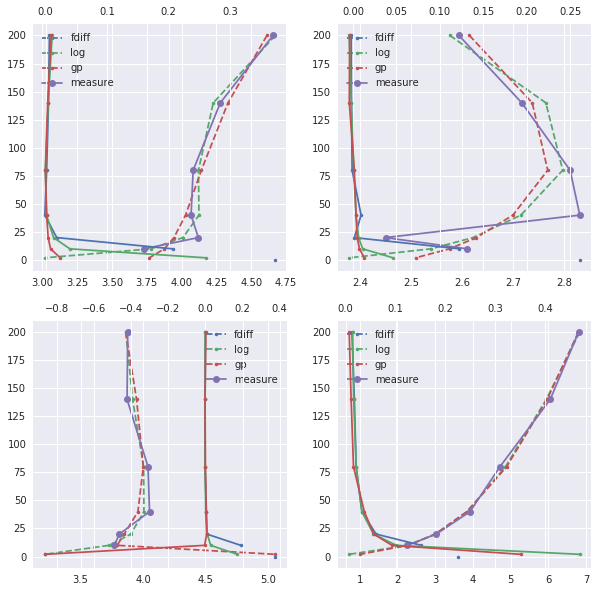

In [71]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = [a for row in axes for a in row]
for i, (ax, tt) in enumerate(zip(axes, [44, 351, 631, 551])):
    plot_profile(tt, towmetds, 'wind', ax)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00000000e+00, -3.45538495e-05,  4.31503449e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.        ,  0.00776987, -0.04637744]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00000000e+00,  9.76933370e-09,  3.39386851e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Program

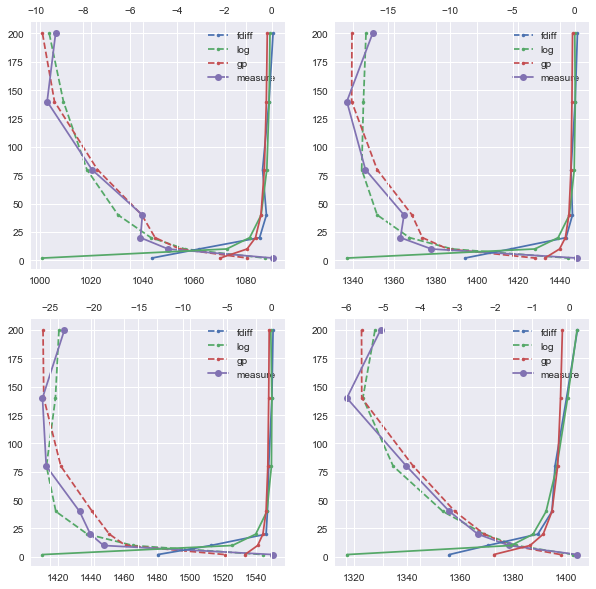

In [74]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = [a for row in axes for a in row]
for i, (ax, tt) in enumerate(zip(axes, [44, 351, 631, 551])):
    plot_profile(tt, towmetds, 'temp', ax)

## computing data

experimental wind shear is computed as

$$
\phi_m\left(\frac{z}{L}\right)=\frac{kz}{u_*}\frac{\partial \overline{U}}{\partial z}
$$

with $\overline{U}$ the average wind speed.

experimental temperature gradient is

$$
\phi_h\left(\frac{z}{L}\right)=
\frac{kz}{\theta_*}\frac{\partial\overline\Theta}{\partial z}=
-\frac{kzu_*c_p\rho}{\overline{w^\prime\Theta_{v_0}^\prime}}\frac{\partial\overline\Theta}{\partial z}
$$

with $\overline{w^\prime\Theta_{v_0}^\prime}$ being the turbulent surface kinematic heat flux and $\theta_*=-\overline{w^\prime\Theta_{v_0}^\prime}/(u_*c_p\rho)$

In [5]:
measurement_cols = ['air_dens', 'H', 'LE', 'ustar', 'wind', 'temp', 'virtual_temp', 'soil_temp', 'z']
index_cols = ['ds', 'year', 'month', 'daym', 'hday', 'tt', 'datetime', 'minute']
computed_cols = ['lval', 'zL', 'model_wind', 'dwdz', 'phi_m', 'model_temp', 'dtdz', 'phi_h']
source_cols = ['IUST', 'ILE', 'IH', 'ITA', 'IF', 'IP0']
additional_cols = ['dewpoint', 'spec_hum', 'rel_hum', 'press', 'rain', 'co2flux', 'soilheat', 'netrad']
RowRecord = namedtuple('RowRecord', index_cols + measurement_cols + computed_cols + source_cols + additional_cols)


def process(month, profile_type, **kwargs):
    try:
        towmetds = Dataset('data/cabauw/cesar_tower_meteo_lc1_t10_v1.0_%s.nc' % month)
        meteods = Dataset('data/cabauw/cesar_surface_meteo_lc1_t10_v1.0_%s.nc' % month)
        fluxds = Dataset('data/cabauw/cesar_surface_flux_lc1_t10_v1.0_%s.nc' % month)
    except:
        import traceback
        print('while loading data for', month)
        traceback.print_exc()
        return

    try:
        soilds = Dataset('data/cabauw/cesar_soil_heat_lb1_t10_v1.0_%s.nc' % month)
    except:
        soilds = None

    for time_index, tt in enumerate(towmetds['time']):
        # compute profiles
        wind_profile = get_wind_profile(time_index, towmetds, profile_type)
        temp_profile = get_temp_profile(time_index, towmetds, profile_type)

        # process each level separately
        for alt_index, z in enumerate(towmetds['z'][:]):
            if z > 50 or z < 2: # outside of the surface layer
                continue

            # retrieve profiles
            if temp_profile.z[alt_index] == z:
                vtemp = temp_profile.measure[alt_index]
                dtemp = temp_profile.derivative[alt_index]
                mtemp = temp_profile.model[alt_index]
            else:
                vtemp = dtemp = mtemp = np.nan

            if wind_profile.z[alt_index] == z:
                wind = wind_profile.measure[alt_index]
                dwind = wind_profile.derivative[alt_index]
                mwind = wind_profile.model[alt_index]
            else:
                wind = dwind = mwind = np.nan

            # compute things
            spec_hum = towmetds['Q'][time_index, alt_index]
            air_dens = 100 * meteods['P0'][time_index] / (287.058 * vtemp)  # kg.m-3

            virtual_potential_temperature_flux = (
                fluxds['H'][time_index] + 0.07 * fluxds['LE'][time_index]
            ) / (1005 * air_dens)

            lval = -fluxds['UST'][time_index]**3 * vtemp / (
                0.35 * 9.81 * virtual_potential_temperature_flux
            )  # m

            phi_m = dwind * 0.35 * z / fluxds['UST'][time_index]
            phi_h = -(
                dtemp * 0.4 * z * fluxds['UST'][time_index]
                / virtual_potential_temperature_flux
            )

            daym = int(tt / 24)
            hday = tt % 24
            minute = 60 * (hday - int(hday))
            second = 60 * (minute - int(minute))

            dt = datetime.datetime(
                year=int(month[:4]), month=int(month[4:]), day=int(daym) + 1,
                hour=int(hday), minute=int(minute), second=int(second)
            )

            yield RowRecord(
                ds=month,
                tt=tt,
                year=dt.year,
                month=dt.month,
                daym=dt.day,
                hday=dt.hour,
                minute=dt.minute,
                datetime=time.mktime(dt.timetuple()),

                air_dens=air_dens,
                H=fluxds['H'][time_index],
                LE=fluxds['LE'][time_index],
                ustar=fluxds['UST'][time_index],
                temp=towmetds['TA'][time_index, alt_index],
                virtual_temp=vtemp,
                soil_temp=(273.15 + soilds['TS00'][time_index]) if soilds else np.nan,
                wind=wind,

                z=z,
                lval=lval,
                zL=z / lval,
                model_wind=mwind,
                model_temp=mtemp,
                dwdz=dwind,
                dtdz=dtemp,
                phi_m=phi_m,
                phi_h=phi_h,

                IUST=fluxds['IUST'][time_index],
                ILE=fluxds['ILE'][time_index],
                IH=fluxds['IH'][time_index],
                ITA=towmetds['ITA'][time_index, alt_index],
                IF=towmetds['IF'][time_index, alt_index],
                IP0=meteods['IP0'][time_index],

                co2flux=fluxds['FC'][time_index],
                soilheat=fluxds['G0'][time_index],
                netrad=fluxds['QN'][time_index],
                spec_hum=spec_hum,
                dewpoint=towmetds['TD'][time_index, alt_index],
                rel_hum=towmetds['RH'][time_index, alt_index],
                press=meteods['P0'][time_index],
                rain=meteods['RAIN'][time_index],
            )

In [6]:
def get_data(dframe_path, **kwargs):
    compression = 'gzip' if dframe_path.endswith('.gz') else None
    sample_size = 7 if 'sample' in dframe_path else 0
    
    if not os.path.exists(dframe_path):
        print('recomputing data for %s (you take a coffee)' % dframe_path)
        import findspark
        findspark.init()

        from pyspark import SparkContext, SparkConf

        sc = SparkContext(conf=SparkConf()
            .setMaster('local[7]')
            .set('spark.driver.memory', '14g')
            .set('spark.driver.maxResultSize', '14g'))
        all_months = set(f[-6-3:-3] for f in os.listdir('data/cabauw') if f.endswith('.nc'))

        bad_rows = sc.accumulator(0)    
        def good_row(row):
            is_good = row.ustar > 0.1 and abs(row.H) > 10 and row.wind > 1
            if not is_good:
                bad_rows.add(1)
            return is_good

        try:
            months_rdd = sc.parallelize(all_months, len(all_months))
            if sample_size > 0:
                months_rdd = months_rdd.sample(
                    withReplacement=False,
                    fraction=sample_size / len(all_months),
                    seed=kwargs.get('seed', None)
                )

            df_rows = (months_rdd
                .flatMap(lambda month: process(month, **kwargs))
                .filter(good_row)
                .collect())
        finally:
            sc.stop()

        print(bad_rows.value, 'rows had bad data')
        print('collected', len(df_rows), 'rows of good data')

        df = pd.DataFrame(df_rows)
        df.to_csv(dframe_path, index=False,
                  compression='gzip' if dframe_path.endswith('.gz') else None)

    try:
        df = pd.read_csv(dframe_path, na_values='--')
    except (OSError, UnicodeDecodeError):
        df = pd.read_csv(dframe_path, na_values='--', compression='gzip')
    
    return df

In [6]:
df = get_data('data/cabauw/processed-full-log.csv.gz')

In [27]:
aa = df.pivot_table(index=['ds', 'tt'], columns='z', values='wind').reset_index().dropna()
aa.head(5)

z      ds        tt       10.0       20.0       40.0
0  200101  0.000000   9.936700  11.027667  12.283668
1  200101  0.166667  10.563969  11.589631  12.510790
2  200101  0.333333   9.838585  10.941726  12.072737
3  200101  0.500000   9.489588  10.562110  11.349895
4  200101  0.666667  10.522912  11.551383  12.352266

In [36]:
aa = df.dropna()
np.corrcoef(aa.soil_temp, aa.dewpoint)

array([[1.        , 0.78842017],
       [0.78842017, 1.        ]])

1929853 bad rows for the full dataset, and 1506563 good ones

we also remove data from 201603 as it contains bad measurements for the fluxes

In [20]:
df[df.ds == 201603][['H', 'LE']].describe().T

count        mean          std          min        25%        50%  \
H   9553.0  314.313909  6980.719147 -1552.988037 -46.030830 -14.380824   
LE  9522.0   46.359942   252.483067 -9660.833000 -17.214043  34.001152   

           75%          max  
H    36.903568  287641.1250  
LE  120.266309    1549.6664

In [21]:
df = df[df.ds != 201603]
print(len(df), 'good records')

1552420 good records


In [238]:
len(df.dropna())

1301574

In [22]:
df[additional_cols].describe(include='all').T

count         mean         std         min          25%  \
dewpoint  1547882.0   280.300422    6.099103  187.966110   276.618870   
spec_hum  1552420.0     6.616596    2.452218   -0.944752     4.806394   
rel_hum   1547882.0    76.561500   15.201796    0.003741    66.956353   
press     1552420.0  1014.220861    9.871962  960.900024  1008.400024   
rain      1552420.0     0.016059    0.124347   -0.016667     0.000000   
co2flux   1552420.0    -0.064074    0.295426   -7.483615    -0.245182   
soilheat  1552420.0     2.867279   15.572178  -77.832718    -6.476648   
netrad    1552420.0    81.474677  167.152922 -158.464615   -35.447525   

                  50%          75%          max  
dewpoint   280.643280   284.576320   296.747620  
spec_hum     6.349312     8.281773    17.782124  
rel_hum     79.173755    88.266014   133.698460  
press     1014.900024  1020.799988  1046.400024  
rain         0.000000     0.000000    15.100000  
co2flux      0.032629     0.116055     6.102142  
soilheat    -0.719930     8.811345  1138.953857  
netrad      -3.014862   171.792969  7775.445312

In [23]:
df[measurement_cols].describe(include='all').T

count         mean         std         min          25%  \
air_dens      1552420.0     0.275836    0.122575    0.100890     0.201929   
H             1552420.0     3.596985   47.269160 -459.999756   -25.835962   
LE            1552420.0    74.574124  114.854946 -534.843600    -4.975750   
ustar         1552420.0     0.308110    0.147369    0.100000     0.198330   
wind          1552420.0     5.856784    2.649183    1.000041     3.980000   
temp          1552420.0   284.701992    6.400130  259.649994   280.149994   
virtual_temp  1552420.0  1441.632639  454.425116  124.793495  1103.014679   
soil_temp     1304764.0   284.326381    5.650719  271.882630   279.602430   
z             1552420.0    23.336230   12.472362   10.000000    10.000000   

                      50%          75%          max  
air_dens         0.254193     0.320078     2.833936  
H              -14.769259    28.045113   479.642334  
LE              23.663866   132.413420  6940.750000  
ustar            0.281670     0.385867     1.848029  
wind             5.426778     7.229194    29.387110  
temp           284.750000   289.350006   306.850006  
virtual_temp  1388.263245  1749.555908  3506.047363  
soil_temp      284.218900   289.057431   302.586436  
z               20.000000    40.000000    40.000000

In [24]:
df[computed_cols].describe(include='all').T

count         mean          std           min          25%  \
lval        1552420.0   128.197253  6714.146194 -1.312652e+06   -25.250362   
zL          1552420.0    -0.075258     1.968372 -1.042494e+02    -0.221416   
model_wind  1552420.0     5.861061     2.648354  5.445866e-01     3.990388   
dwdz        1552420.0     0.060931     0.045620 -3.074057e-01     0.030841   
phi_m       1552420.0     1.617365     1.510628 -9.456479e+00     0.673852   
model_temp  1552420.0  1442.105360   453.696640 -1.090825e+02  1102.747672   
dtdz        1552420.0    -0.854853     2.604479 -9.633443e+01    -1.289514   
phi_h       1552420.0    -4.654602  1364.942973 -8.958161e+05   -14.762582   

                    50%          75%           max  
lval          25.943692   137.509058  3.995551e+06  
zL             0.061049     0.349177  2.925918e+01  
model_wind     5.434145     7.232351  2.948378e+01  
dwdz           0.053765     0.081066  8.532897e-01  
phi_m          1.153790     2.043250  1.503653e+01  
model_temp  1388.449618  1749.259404  3.451073e+03  
dtdz          -0.567229    -0.179261  1.014841e+02  
phi_h         -0.063020    10.961095  3.321678e+05

In [25]:
df[index_cols].describe(include='all').T

count          mean           std          min           25%  \
ds        1552420.0  2.008975e+05  4.881996e+02     200101.0  2.005030e+05   
year      1552420.0  2.008910e+03  4.881137e+00       2001.0  2.005000e+03   
month     1552420.0  6.424853e+00  3.419170e+00          1.0  4.000000e+00   
daym      1552420.0  1.565950e+01  8.809076e+00          1.0  8.000000e+00   
hday      1552420.0  1.163536e+01  6.537744e+00          0.0  7.000000e+00   
tt        1552420.0  3.638802e+02  2.115231e+02          0.0  1.805000e+02   
datetime  1552420.0  1.243418e+09  1.545008e+08  978303600.0  1.110316e+09   
minute    1552420.0  2.490446e+01  1.705664e+01          0.0  1.000000e+01   

                   50%           75%           max  
ds        2.009050e+05  2.013090e+05  2.017120e+05  
year      2.009000e+03  2.013000e+03  2.017000e+03  
month     6.000000e+00  9.000000e+00  1.200000e+01  
daym      1.600000e+01  2.300000e+01  3.100000e+01  
hday      1.200000e+01  1.700000e+01  2.300000e+01  
tt        3.615000e+02  5.453334e+02  7.438334e+02  
datetime  1.241820e+09  1.378071e+09  1.514761e+09  
minute    3.000000e+01  4.000000e+01  5.000000e+01

In [26]:
df[source_cols].describe(include='all').T

count      mean       std  min  25%  50%  75%  max
IUST  1552420.0  2.254951  0.686953  2.0  2.0  2.0  2.0  7.0
ILE   1552420.0  2.459457  1.281570  2.0  2.0  2.0  2.0  7.0
IH    1552420.0  2.411393  1.203921  2.0  2.0  2.0  2.0  7.0
ITA   1552420.0  2.043940  0.436625  2.0  2.0  2.0  2.0  7.0
IF    1552420.0  2.025575  0.338275  2.0  2.0  2.0  2.0  7.0
IP0   1552420.0  3.031298  0.346980  3.0  3.0  3.0  3.0  7.0

<Figure size 1080x360 with 0 Axes>

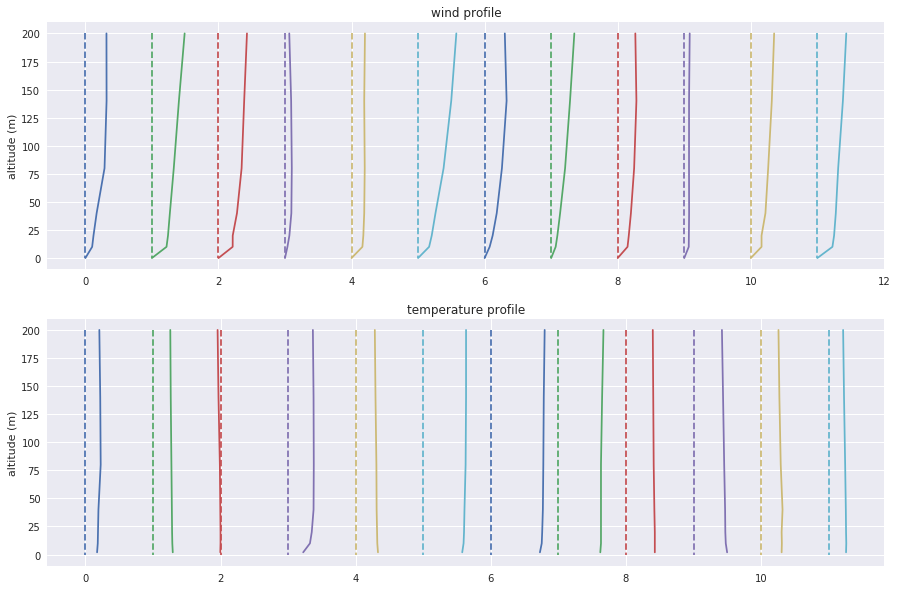

In [233]:
plt.figure(figsize=(15, 5))

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(15, 10)

ax1.set_title('wind profile')
ax1.set_ylabel('altitude (m)')

ax2.set_title('temperature profile')
ax2.set_ylabel('altitude (m)')

#for i, tt in enumerate(towmetds['time'][::250]):
for i in range(12):
    month = df[df.month == 1 + i].sample(1).ds.values[0]

    towmetds = Dataset('data/cabauw/cesar_tower_meteo_lc1_t10_v1.0_%s.nc' % month)
    tt = np.random.choice(towmetds['time'][:])
    
    ws = towmetds['F'][tt][:-1]
    qq = ax1.plot([i + w / 25 for w in ws] + [i], list(towmetds['z'][:-1]) + [0], 'x-')
    ax1.plot([i, i], [200, 0], '--', c=qq[0]._color)
    
    ts = towmetds['TA'][tt]
    qq = ax2.plot([i + (t - 273.15) / 30 for t in ts], towmetds['z'][:], 'x-')
    ax2.plot([i, i], [200, 0], '--', c=qq[0]._color)

plt.show()

## Compare gradients computed with finite differences, log profile and gaussian process

In [7]:
gp_df = get_data('data/cabauw/processed-full-gp.csv.gz', profile_type='gp')
log_df = get_data('data/cabauw/processed-full-log.csv.gz', profile_type='log')
fd_df = get_data('data/cabauw/processed-full-fdiff.csv.gz', profile_type='fdiff')

In [8]:
features = ['ds', 'tt', 'z', 'wind', 'model_wind', 'dwdz', 'phi_m']

merged = gp_df[features].merge(
    log_df[features], on=['ds', 'tt', 'z'], suffixes=('_gp', '_log')
).merge(
    fd_df[features], on=['ds', 'tt', 'z'], suffixes=('', '')
).rename({
    'wind': 'wind_fd',
    'model_wind': 'model_wind_fd',
    'dwdz': 'dwdz_fd',
    'phi_m': 'phi_m_fd'
}, axis=1)

compute r squared between measured wind and modeled wind

In [9]:
r2s = merged.groupby(['ds', 'tt']).apply(lambda g: pd.Series({
    'gp_wind_r2': r2_score(g.wind_gp, g.model_wind_gp),
    'log_wind_r2': r2_score(g.wind_log, g.model_wind_log)
})).reset_index()

merged = merged.merge(r2s, on=['ds', 'tt'])
merged[['gp_wind_r2', 'log_wind_r2']].describe(
    percentiles=[0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75]
)

gp_wind_r2   log_wind_r2
count  1.561973e+06  1.561973e+06
mean  -2.063462e+00 -2.142023e+02
std    1.007293e+03  1.534549e+05
min   -7.158117e+05 -1.107250e+08
1%    -6.043920e-01 -8.102018e-01
2.5%   5.670823e-02  1.044802e-01
5%     4.806502e-01  5.642110e-01
10%    7.578563e-01  8.246555e-01
25%    9.280123e-01  9.489716e-01
50%    9.837910e-01  9.834238e-01
75%    9.982311e-01  9.948418e-01
max    1.000000e+00  1.000000e+00

note: here we are computing the r-squared considering only the levels 10/20/40, which are the most sensitive. the r-squared on all levels has a much lighter left tail, with the minimum being between -10 and 0, but there is not much difference in distribution otherwise. using only the three levels is more relevant in our case tho, since we want to compare with finite differences on these levels only

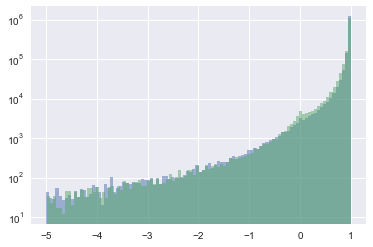

In [10]:
r2_filter = (merged.log_wind_r2 > -5) & (merged.gp_wind_r2 > -5)
_ = plt.hist(merged[r2_filter].log_wind_r2, bins=100, alpha=0.5)
_ = plt.hist(merged[r2_filter].gp_wind_r2, bins=100, alpha=0.5)
plt.yscale('log')

the distribution is practically identical

plot the correlation between the gradients, green is z=10, blue is z=20 and z=40

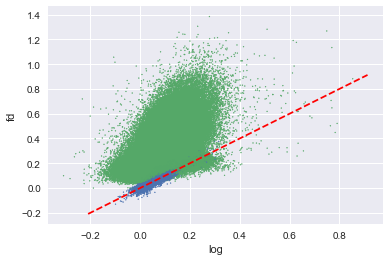

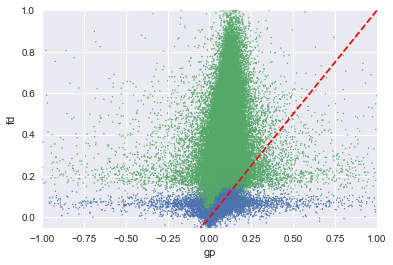

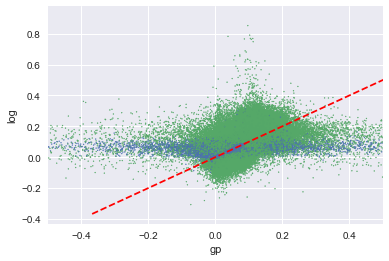

In [11]:
def plot_corr(datax, datay, **kwargs):
    plt.scatter(datax, datay, **kwargs)
    (ymin, ymax), (xmin, xmax) = plt.ylim(), plt.xlim()
    lmin, lmax = max(xmin, ymin), min(xmax, ymax)
    plt.plot([lmin, lmax], [lmin, lmax], 'r--')

colors = c=['C0' if z > 10 else 'C1' for z in merged.z]
plot_corr(merged.dwdz_log, merged.dwdz_fd, s=1, c=colors)
plt.xlabel('log'); plt.ylabel('fd'); plt.show()

plot_corr(merged.dwdz_gp, merged.dwdz_fd, s=1, c=colors)
plt.ylim(-0.05, 1); plt.xlim(-1, 1)
plt.xlabel('gp'); plt.ylabel('fd'); plt.show()

plot_corr(merged.dwdz_gp, merged.dwdz_log, s=1, c=colors)
plt.xlabel('gp'); plt.ylabel('log')
plt.xlim(-0.5, 0.5); plt.show()

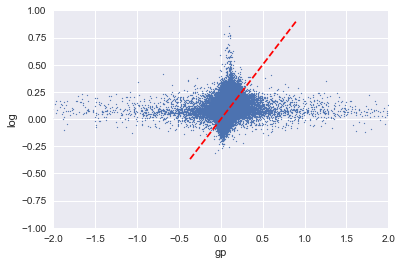

In [12]:
plot_corr(merged.dwdz_gp, merged.dwdz_log, s=1)
plt.xlabel('gp'); plt.ylabel('log')
plt.xlim(-2, 2)
plt.ylim(-1, 1)
plt.show()

the finite differences gradient gives very different estimates at z=10, whereas log and gp somewhat agree

compute correlation coefficient between pairs of gradients at all levels

In [13]:
merged.groupby('z').apply(lambda g: pd.Series({
    'log_gp_corr': np.corrcoef(g.dwdz_log, g.dwdz_gp)[0, 1],
    'log_fd_corr': np.corrcoef(g.dwdz_log, g.dwdz_fd)[0, 1],
    'gp_fd_corr': np.corrcoef(g.dwdz_gp, g.dwdz_fd)[0, 1],
})).reset_index()

z  gp_fd_corr  log_fd_corr  log_gp_corr
0  10.0    0.071622     0.478314     0.126641
1  20.0    0.235333     0.979258     0.240898
2  40.0    0.546330     0.960191     0.541323

gradients are poorly correlated at z=10, especially fd

In [14]:
merged.groupby('z').apply(lambda g: g[['dwdz_log', 'dwdz_gp']].describe())

dwdz_log        dwdz_gp
z                                       
10.0 count  520436.000000  520436.000000
     mean        0.090066       0.076650
     std         0.059114       0.221754
     min        -0.307406     -59.109140
     25%         0.048794       0.048214
     50%         0.087125       0.079300
     75%         0.127002       0.102946
     max         0.853290      56.808117
20.0 count  520715.000000  520715.000000
     mean        0.055659       0.053298
     std         0.029150       0.108971
     min        -0.098715     -29.948619
     25%         0.034489       0.031587
     50%         0.058119       0.056540
     75%         0.075878       0.073065
     max         0.344491      26.115948
40.0 count  520822.000000  520822.000000
     mean        0.037063       0.037865
     std         0.021242       0.038388
     min        -0.046256     -10.607107
     25%         0.019288       0.019182
     50%         0.039130       0.040239
     75%         0.051926       0.053233
     max         0.157134       9.290767

compute the squared and percent error of the modeled winds (gp and log) for every level

In [15]:
merged.assign(
    log_se=lambda d: (d.model_wind_log - d.wind_log)**2,
    gp_se=lambda d: (d.model_wind_gp - d.wind_gp)**2,
    log_pe=lambda d: np.abs(1 - d.model_wind_log / d.wind_log) * 100,
    gp_pe=lambda d: np.abs(1 - d.model_wind_gp / d.wind_gp) * 100
).groupby('z').apply(lambda g: g[['log_se', 'gp_se', 'log_pe', 'gp_pe']].describe())

log_se         gp_se         log_pe         gp_pe
z                                                                  
10.0 count  5.204360e+05  5.204360e+05  520436.000000  5.204360e+05
     mean   5.057743e-03  7.696732e-01       1.224964  1.800637e+00
     std    1.446854e-02  2.142668e+02       1.403314  2.788832e+01
     min    1.580586e-14  2.569559e-18       0.000002  4.007461e-08
     25%    3.200218e-04  6.597141e-05       0.371423  1.791894e-01
     50%    1.554141e-03  1.258659e-03       0.821672  7.726014e-01
     75%    5.229409e-03  8.301618e-03       1.550500  1.914239e+00
     max    1.572152e+00  1.268854e+05      53.754071  1.736004e+04
20.0 count  5.207150e+05  5.207150e+05  520715.000000  5.207150e+05
     mean   2.395233e-02  4.348544e-02       2.260520  1.800850e+00
     std    7.402268e-02  5.080403e+00       2.343245  5.948863e+00
     min    9.153012e-14  1.837535e-17       0.000005  2.477831e-08
     25%    1.581865e-03  2.948149e-04       0.744696  3.299581e-01
     50%    7.622978e-03  3.842834e-03       1.625129  1.168725e+00
     75%    2.535107e-02  1.764070e-02       2.964241  2.428959e+00
     max    8.910873e+00  2.503064e+03     106.562310  3.678723e+03
40.0 count  5.208220e+05  5.208220e+05  520822.000000  5.208220e+05
     mean   1.295198e-02  5.041265e-01       1.387807  1.551516e+00
     std    5.055311e-02  1.340375e+02       1.478332  1.515048e+01
     min    4.839855e-14  6.957496e-17       0.000004  1.766878e-07
     25%    8.463844e-04  1.459880e-04       0.474397  2.017460e-01
     50%    4.001073e-03  2.464036e-03       1.026265  8.250214e-01
     75%    1.287998e-02  1.485642e-02       1.841316  1.953979e+00
     max    9.180017e+00  7.229522e+04      80.353093  9.407826e+03

the mse at z=10 is not significantly different from the mse at higher levels, therefore, it seems reasonable to conclude that the gradients from the models are correct, and the fd gradient is wrong at that level. in fact, because of the no-slip condition, the derivative at z=10 is computed as the wind at z=20 divided by 20

In [16]:
perrs = merged.assign(
    log_se=lambda d: (d.model_wind_log - d.wind_log)**2,
    gp_se=lambda d: (d.model_wind_gp - d.wind_gp)**2,
    log_pe=lambda d: np.abs(1 - d.model_wind_log / d.wind_log) * 100,
    gp_pe=lambda d: np.abs(1 - d.model_wind_gp / d.wind_gp) * 100
)

Text(0,0.5,'Absolute Percent Error')

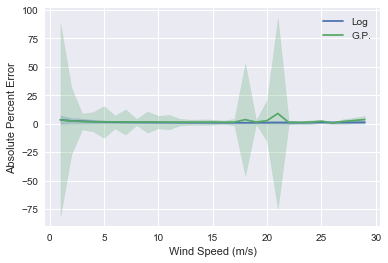

In [22]:
wserr = perrs.groupby(
    perrs.wind_log.astype(int)
).apply(lambda g: pd.Series([
    g.log_pe.mean(), g.log_pe.std(),
    g.gp_pe.mean(), g.gp_pe.std()
], index=['mean_log_pe', 'std_log_pe', 'mean_gp_pe', 'std_gp_pe'])).reset_index().dropna()


plt.plot(wserr.wind_log, wserr.mean_log_pe, label='Log')
plt.fill_between(
    wserr.wind_log,
    wserr.mean_log_pe - wserr.std_log_pe,
    wserr.mean_log_pe + wserr.std_log_pe,
    color='C0', alpha=0.25
)

plt.plot(wserr.wind_log, wserr.mean_gp_pe, label='G.P.')

plt.fill_between(
    wserr.wind_log,
    wserr.mean_gp_pe - wserr.std_gp_pe,
    wserr.mean_gp_pe + wserr.std_gp_pe,
    color='C1', alpha=0.25
)
plt.legend(loc='upper right')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Absolute Percent Error')

30 m/s wind seems unreasonable

In [18]:
merged.wind_log.describe(percentiles=[0.5,0.75,0.9,0.95,0.975,0.99])

count    1.561973e+06
mean     5.855102e+00
std      2.650776e+00
min      1.000041e+00
50%      5.422268e+00
75%      7.228788e+00
90%      9.369867e+00
95%      1.089449e+01
97.5%    1.231000e+01
99%      1.404000e+01
max      2.938711e+01
Name: wind_log, dtype: float64

In [19]:
153/3.6

42.5

No handles with labels found to put in legend.


([<matplotlib.axis.XTick at 0x2da8cd35898>,
 <a list of 8 Text xticklabel objects>)

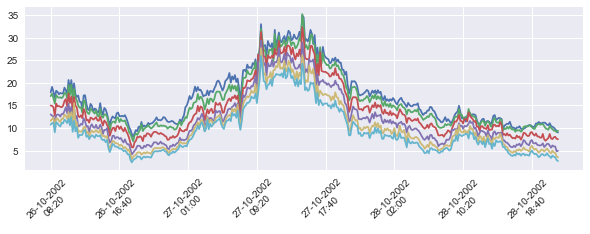

In [25]:
jeanette_ds = Dataset('data/cabauw/cesar_tower_meteo_lc1_t10_v1.0_200210.nc')

start, end = 3650, 4020
times = range(3650, 4020)
wind = jeanette_ds['F'][times]

plt.figure(figsize=(10, 3))
plt.plot(wind)
plt.legend()

ticks, _ = plt.xticks()
datetimes = [
    datetime.datetime(
        day=1, month=10, year=2002
    ) + datetime.timedelta(
        minutes=10 * (start + offs)
    ) for offs in ticks
]
labels = ['%d-%d-%d\n%02d:%02d' % (row.day, row.month, row.year, row.hour, row.minute) for row in datetimes]
plt.xticks(ticks[1:-1], labels[1:-1], rotation=45)

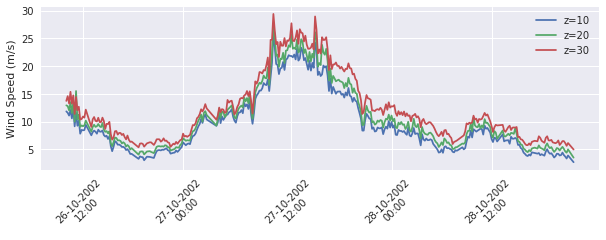

In [208]:
jeanette_ds = Dataset('data/cabauw/cesar_tower_meteo_lc1_t10_v1.0_200210.nc')

plt.figure(figsize=(10, 3))
plt.plot(log_df[ff & (log_df.z == 10)].datetime, log_df[ff & (log_df.z == 10)].wind, label='z=10')
plt.plot(log_df[ff & (log_df.z == 20)].datetime, log_df[ff & (log_df.z == 20)].wind, label='z=20')
plt.plot(log_df[ff & (log_df.z == 40)].datetime, log_df[ff & (log_df.z == 40)].wind, label='z=30')
ticks = log_df[ff & (log_df.z == 10) & (log_df.hday % 12 == 0) & (log_df.minute == 0)]
plt.xticks(ticks.datetime, ticks.apply(
    lambda row: '%d-%d-%d\n%02d:%02d' % (row.daym, row.month, row.year, row.hday, row.minute),
    axis=1
), rotation=45)
plt.legend(loc='upper right')
plt.ylabel('Wind Speed (m/s)')
plt.show()

In [26]:
merged.assign(
    log_se=lambda d: (d.model_wind_log - d.wind_log)**2,
    gp_se=lambda d: (d.model_wind_gp - d.wind_gp)**2,
    log_pe=lambda d: np.abs(1 - d.model_wind_log / d.wind_log) * 100,
    gp_pe=lambda d: np.abs(1 - d.model_wind_gp / d.wind_gp) * 100
).groupby(
    np.digitize(merged.wind_log, [1, 3, 5, 7])
).apply(lambda g: g[[ 'log_pe', 'gp_pe']].describe())

log_pe         gp_pe
1 count  168937.000000  1.689370e+05
  mean        2.694822  2.634070e+00
  std         3.043493  5.017920e+01
  min         0.000015  2.424500e-07
  25%         0.790282  2.707074e-01
  50%         1.808552  1.228519e+00
  75%         3.535414  2.926206e+00
  max       106.562310  1.736004e+04
2 count  496732.000000  4.967320e+05
  mean        1.932299  1.794995e+00
  std         2.035901  7.792683e+00
  min         0.000015  4.007461e-08
  25%         0.588252  1.822084e-01
  50%         1.319798  9.247535e-01
  75%         2.555588  2.240387e+00
  max        49.961610  2.533982e+03
3 count  467961.000000  4.679610e+05
  mean        1.393452  1.560265e+00
  std         1.355347  1.106187e+01
  min         0.000004  8.774186e-08
  25%         0.470290  2.028897e-01
  50%         1.031782  8.381922e-01
  75%         1.897448  1.972568e+00
  max        45.510878  6.130977e+03
4 count  428343.000000  4.283430e+05
  mean        1.097791  1.438433e+00
  std         1.055708  8.338165e+00
  min         0.000002  2.477831e-08
  25%         0.378226  2.748063e-01
  50%         0.830083  8.928851e-01
  75%         1.504316  1.894528e+00
  max        35.014851  3.374002e+03

now we bin wind into the intervals (1,2), (2,3), (3,4), (4,)

In [27]:
merged.groupby(
    np.digitize(merged.wind_log, [1, 2, 3, 4])
)[['log_wind_r2', 'gp_wind_r2', 'wind_log']].describe(percentiles=[]).T

1              2              3             4
log_wind_r2 count  4.427600e+04  124661.000000  226722.000000  1.166314e+06
            mean  -7.585700e+03       0.158587       0.749205  9.402019e-01
            std    9.114301e+05      24.684880      14.536616  1.568623e+00
            min   -1.107250e+08   -3597.037155   -3352.170898 -8.511206e+02
            50%    7.023171e-01       0.953026       0.977936  9.864987e-01
            max    9.999921e-01       1.000000       1.000000  1.000000e+00
gp_wind_r2  count  4.427600e+04  124661.000000  226722.000000  1.166314e+06
            mean  -7.134447e+01      -1.636225       0.657076 -7.908456e-03
            std    5.751415e+03     666.573387      27.747912  2.351538e+02
            min   -7.158117e+05 -233706.735954   -8710.514882 -1.100253e+05
            50%    7.661030e-01       0.967383       0.986912  9.849901e-01
            max    1.000000e+00       1.000000       1.000000  1.000000e+00
wind_log    count  4.427600e+04  124661.000000  226722.000000  1.166314e+06
            mean   1.589983e+00       2.576652       3.522886  6.820795e+00
            std    2.714445e-01       0.280636       0.283565  2.356725e+00
            min    1.000041e+00       2.000000       3.000000  4.000000e+00
            50%    1.620000e+00       2.610000       3.540000  6.220000e+00
            max    1.999983e+00       2.999995       3.999925  2.938711e+01

low r2 scores occur in low wind conditions

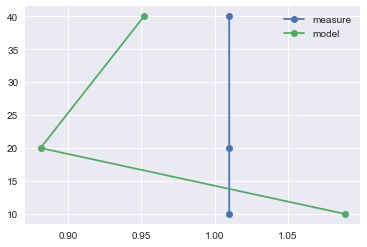

In [28]:
minr2 = merged.iloc[merged.log_wind_r2.idxmin()]
minr2 = merged[(merged.ds == minr2.ds) & (merged.tt == minr2.tt)]
plt.plot(minr2.wind_log, minr2.z, 'o-', label='measure')
plt.plot(minr2.model_wind_log, minr2.z, 'o-', label='model')
plt.legend()

this happens when the wind is roughly constant at 10/20/40, then it has a very low std. which blows up the r2. note that we are modeling the wind at all levels, that's why the model is very far from the actual value

In [29]:
sum(merged.gp_wind_r2 < 0.9) / len(merged), sum(merged.log_wind_r2 < 0.9) / len(merged)

(0.20170323046557143, 0.15206280774379582)

In [30]:
sum(merged.z == 10) / len(merged)

0.3331914188017335

we have low r-squared in 15% or less of the data. considering the model allows us to use data at z=10, it is worth it

arguably, the most accurate method of computing the gradient is the one that works better under the MOST

In [31]:
def phi_m(zL):
    if zL < 0:
        return math.pow(1 - 19.3 * zL, -0.25)
    else:
        return 1 + 4.7 * zL

def ff(df):
    return (df.zL > -2) & (df.zL < 1)
    
with TempVar(log_df=log_df[ff(log_df)], gp_df=gp_df[ff(gp_df)], fd_df=fd_df[ff(fd_df)]):
    log_mse = np.mean((log_df.phi_m - np.array(list(map(phi_m, log_df.zL))))**2)
    gp_mse = np.mean((gp_df.phi_m - np.array(list(map(phi_m, gp_df.zL))))**2)
    fd_mse = np.mean((fd_df.phi_m - np.array(list(map(phi_m, fd_df.zL))))**2)
    fd_10_mse = np.mean((fd_df[fd_df.z > 10].phi_m - np.array(list(map(phi_m, fd_df[fd_df.z > 10].zL))))**2)

    print('MSE with log:', log_mse)
    print('MSE with gp:', gp_mse)
    print('MSE with finite differences:', fd_mse)
    print('MSE with finite differences without z=10:', fd_10_mse)

NameError: name 'TempVar' is not defined

In [34]:
sum(ff(log_df)) / len(log_df)

0.8366668309887559

In [35]:
def phi_m(zL):
    if zL < 0:
        return math.pow(1 - 19.3 * zL, -0.25)
    else:
        return 1 + 4.7 * zL

log_mse = np.mean((log_df.phi_m - np.array(list(map(phi_m, log_df.zL))))**2)
gp_mse = np.mean((gp_df.phi_m - np.array(list(map(phi_m, gp_df.zL))))**2)
fd_mse = np.mean((fd_df.phi_m - np.array(list(map(phi_m, fd_df.zL))))**2)
fd_10_mse = np.mean((fd_df[fd_df.z > 10].phi_m - np.array(list(map(phi_m, fd_df[fd_df.z > 10].zL))))**2)

print('MSE with log:', log_mse)
print('MSE with gp:', gp_mse)
print('MSE with finite differences:', fd_mse)
print('MSE with finite differences without z=10:', fd_10_mse)

MSE with log: 8.498116088086423
MSE with gp: 14.784622772404653
MSE with finite differences: 9.321601315874231
MSE with finite differences without z=10: 11.832506123733909


to conclude, log model works better (despite in theory it only applies to stable conditions), and allows us to use z=10, increasing available data by a good 33%

NameError: name 'xx' is not defined

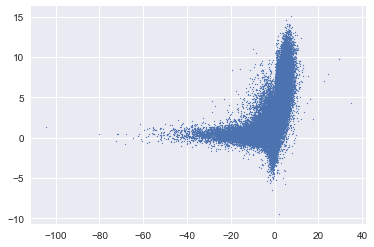

In [36]:
plt.scatter(log_df.zL, log_df.phi_m, s=1)
plt.plot(xx, list(map(phi_m, xx)), 'r')
plt.ylim(-2, 10)
plt.xlim(-2, 2)

In [ ]:
plt.scatter(gp_df.zL, gp_df.phi_m, s=1)
plt.plot(xx, list(map(phi_m, xx)), 'r')
plt.ylim(-2, 10)
plt.xlim(-2, 2)

## check correlations to see if things make sense

plot correlation matrix between data, computed values, and time of year (to check seasonality)

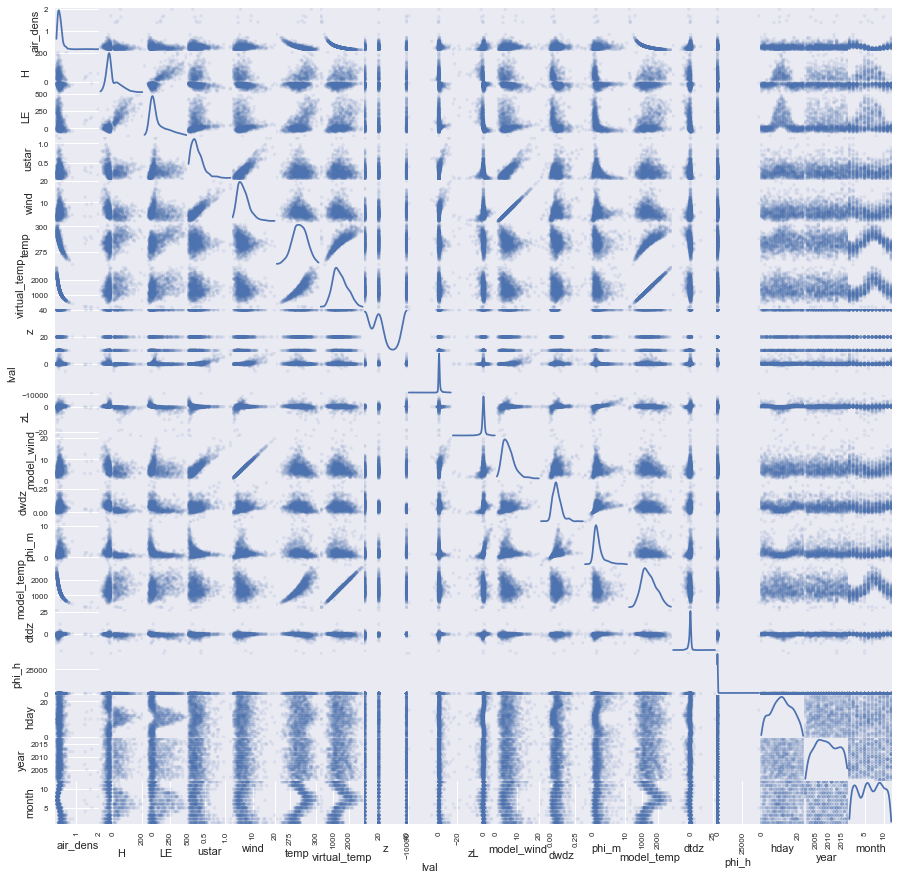

In [192]:
_ = pd.plotting.scatter_matrix(
    df.sample(1000)[measurement_cols + computed_cols + ['hday', 'year', 'month']].drop('soil_temp', axis=1),
    figsize=(15, 15), alpha=0.1, diagonal='kde'
)

## check ustar and wind

In [253]:
from sklearn.model_selection import ShuffleSplit

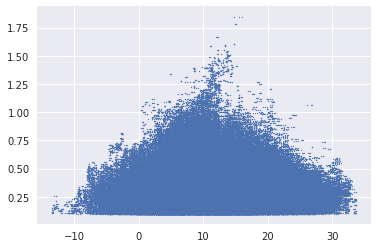

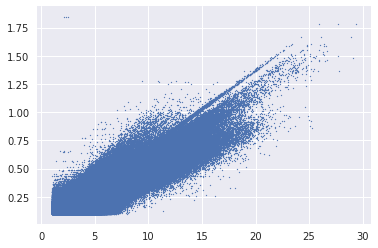

In [181]:
plt.scatter(df.temp - 273.15, df.ustar, s=1); plt.show()
plt.scatter(df.wind, df.ustar, s=1); plt.show()

a subset of the data presents a very different correlation between wind and ustar, I wonder why is it

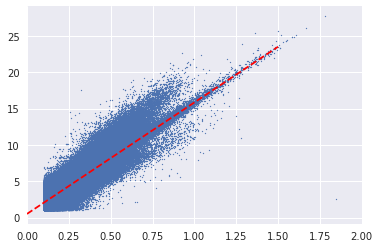

In [115]:
with TempVar(df=df[df.z==20]):
    plt.scatter(df.ustar, df.wind, s=1)
    plt.xlim(0, 2)
    plt.plot([0, 1.5], [0.5, 23.5], 'r--')

seems like $y=23.5 / 1.5 x + 0.5$ fits well, now we can partition the data based on the distance to this line

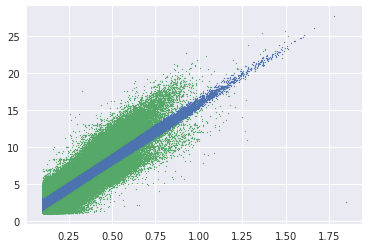

In [127]:
with TempVar(df=df[df.z==20]):
    ustarwindpred = 0.7 + df.ustar * 23 / 1.5
    df = df.assign(cls=np.abs(ustarwindpred - df.wind) < 1)

    with TempVar(df=df[df.cls == 1]):
        plt.scatter(df.ustar, df.wind, s=1)
    with TempVar(df=df[df.cls == 0]):
        plt.scatter(df.ustar, df.wind, s=1)

    aa = df

to see if there are "significant" differences, we compute the effect size between the two groups, for every column

In [156]:
ess = []
for col in aa.columns:
    n1, n2 = sum(aa.cls == 1), sum(aa.cls == 0)
    std1, std2 = aa[aa.cls == 1][col].std(), aa[aa.cls == 0][col].std()
    mu1, mu2 = aa[aa.cls == 1][col].mean(), aa[aa.cls == 0][col].mean()
    
    pstd = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 1))
    es = (mu1 - mu2) / pstd
    ess.append((col, es))

list(sorted(ess, key=lambda x: -abs(x[1])))

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


[('cls', inf),
 ('IUST', 0.40276584134018856),
 ('IH', 0.3889164579265222),
 ('ILE', 0.34589663729751746),
 ('wind', -0.30419375873880605),
 ('model_wind', -0.2964788923137755),
 ('phi_m', -0.2009168172568465),
 ('dwdz', -0.1945837068381114),
 ('soil_temp', 0.1856555167210255),
 ('model_temp', 0.1346996584445064),
 ('virtual_temp', 0.13432784895732444),
 ('spec_hum', 0.13411817151093924),
 ('press', 0.12724234064882878),
 ('rain', 0.10816043647041727),
 ('dewpoint', 0.09730076001230913),
 ('temp', 0.09611655223623841),
 ('zL', -0.0875131842930982),
 ('dtdz', -0.08320140706441168),
 ('H', 0.06753585174373748),
 ('air_dens', -0.062146805266259826),
 ('co2flux', 0.04170190643391599),
 ('IF', -0.04127601702415018),
 ('soilheat', -0.03922177966210217),
 ('netrad', 0.036559773645264214),
 ('LE', 0.03257678126517579),
 ('month', 0.02510072839401684),
 ('ustar', -0.02050726255551238),
 ('rel_hum', 0.019896010047569763),
 ('datetime', 0.018774492442160957),
 ('ds', 0.017541358081100904),
 ('yea

the biggest difference is in the source columns IUST, IH and ILE, and in the wind, but given the scatter plot we know this last difference is spurious:

/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


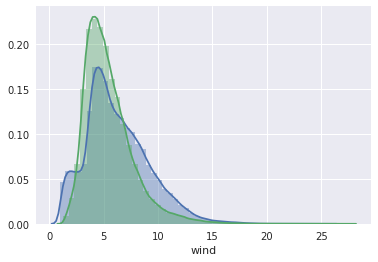

In [158]:
sns.distplot(aa[aa.cls == 0].wind)
sns.distplot(aa[aa.cls == 1].wind)

since the source columns are discrete, comparing the counts is a much better way

In [155]:
aa.groupby('cls').apply(lambda g: pd.DataFrame([
    g.groupby('IUST').size(),
    g.groupby('ILE').size(),
    g.groupby('IH').size(),
], index=['IUST', 'ILE', 'IH']))

2.0      4.0     5.0      6.0     7.0
cls                                                   
False IUST  197881.0   8435.0   143.0     40.0   313.0
      ILE   196965.0      NaN  1436.0   5605.0  2806.0
      IH    199607.0      NaN  1227.0   5596.0   382.0
True  IUST  255175.0  54699.0   222.0    176.0   432.0
      ILE   260715.0      NaN  6507.0  39897.0  3585.0
      IH    263233.0      NaN  6279.0  39855.0  1337.0

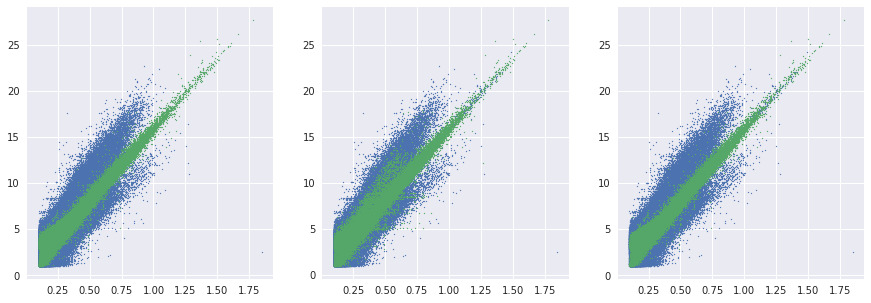

In [160]:
plt.figure(figsize=(15, 5))
for i, col in enumerate(['IUST', 'ILE', 'IH']):
    plt.subplot(1, 3, i + 1)
    with TempVar(aa=aa[aa[col] == 2]):
        plt.scatter(aa.ustar, aa.wind, s=1)

    with TempVar(aa=aa[aa[col] != 2]):
        plt.scatter(aa.ustar, aa.wind, s=1)

this seems to explain the difference

## check $\phi_m$

/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


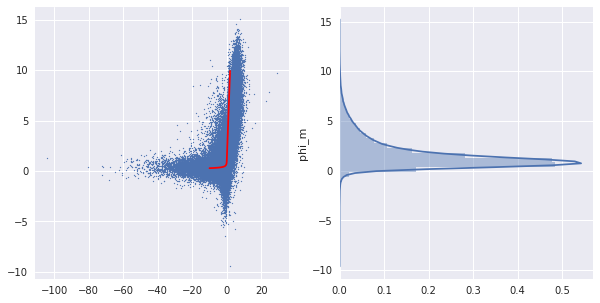

In [216]:
def phi_m(zL):
    if zL < 0:
        return math.pow(1 - 15 * zL, -0.25)
    else:
        return 1 + 4.7 * zL


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(df.zL, df.phi_m, s=1)
xx = np.arange(-10, 2, 0.1)
plt.plot(xx, list(map(phi_m ,xx)), 'r')
#plt.xlim(-10, 10)

plt.subplot(1, 2, 2)
sns.distplot(df.phi_m.dropna(), vertical=True)

plt.show()

looks wrong but it actually is correct, as the MOST is valid with z/L<1 or so, afterwards the curve levels off and becomse independent from it (citation somewhere)

(-2, 10)

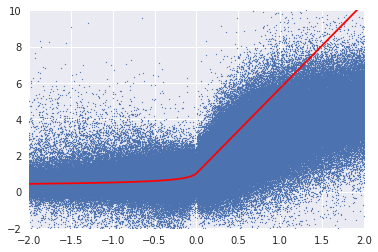

In [213]:
xx = np.arange(-50, 10, 0.01)
phimx = list(map(phi_m ,xx))
plt.scatter(df.zL, df.phi_m, s=1)
plt.plot(xx, phimx, 'r-')
plt.xlim(-2, 2)
plt.ylim(-2, 10)

(-2, 20)

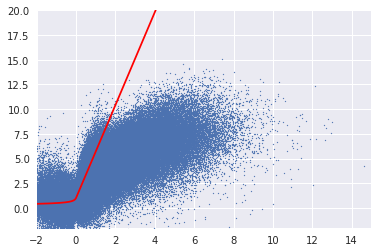

In [215]:
xx = np.arange(-50, 10, 0.01)
phimx = list(map(phi_m ,xx))
plt.scatter(df.zL, df.phi_m, s=1)
plt.plot(xx, phimx, 'r-')
plt.xlim(-2, 15)
plt.ylim(-2, 20)

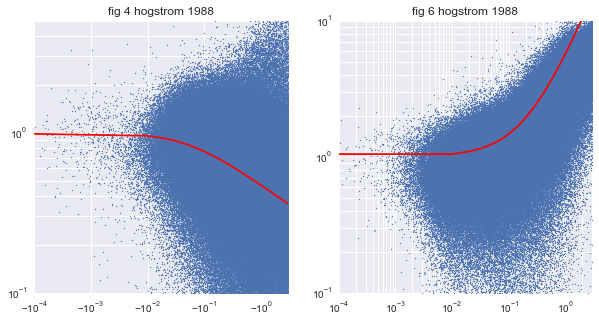

In [195]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(df.zL, df.phi_m, s=1)

plt.plot(xx, phimx, 'r')
plt.xlim(-3, -0.0001)
plt.xscale('symlog', linthreshx=0.0001)
plt.ylim(0.1, 5)
plt.yscale('log')
plt.title('fig 4 hogstrom 1988')
plt.gca().invert_xaxis()
plt.grid(True, 'both')

plt.subplot(1, 2, 2)
plt.scatter(df.zL, df.phi_m, s=1)
plt.plot(xx, phimx, 'r')
plt.xlim(0.0001, 3)
plt.xscale('log')
plt.ylim(0.1, 10)
plt.yscale('log')
plt.title('fig 6 hogstrom 1988')
plt.grid(True, 'both')
plt.show()

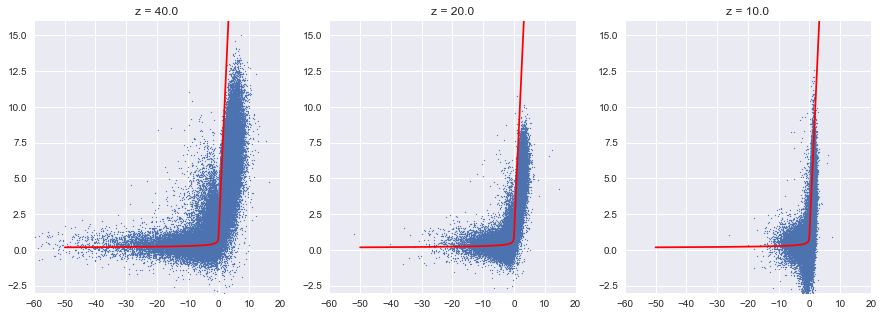

In [211]:
plt.figure(figsize=(15, 5))
for i, z in enumerate(df.z.unique()):
    plt.subplot(1, 3, i + 1)
    plt.title('z = %.1f' % z)
    plt.scatter(df[df.z == z].zL, df[df.z == z].phi_m, s=1)
    plt.plot(xx, phimx, 'r')
    plt.xlim(-60, 20)
    plt.ylim(-3, 16)

plt.show()

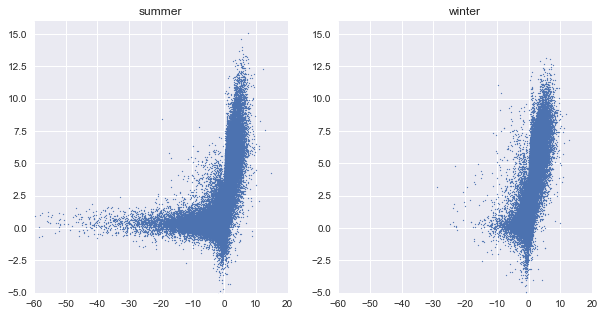

In [198]:
winter = [11, 12, 1, 2]
summer = [6, 7, 8]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('summer')
plt.scatter(df[df.month.isin(summer)].zL, df[df.month.isin(summer)].phi_m, s=1)
plt.xlim(-60, 20)
plt.ylim(-5, 16)

plt.subplot(1, 2, 2)
plt.title('winter')
plt.scatter(df[df.month.isin(winter)].zL, df[df.month.isin(winter)].phi_m, s=1)
plt.xlim(-60, 20)
plt.ylim(-5, 16)
plt.show()

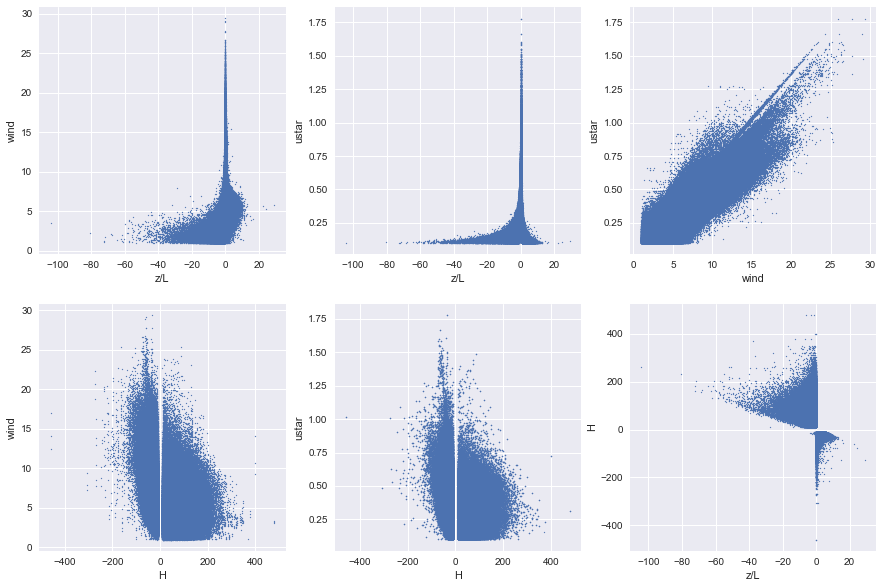

In [199]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.ylabel('wind'); plt.xlabel('z/L')
plt.scatter(df.zL, df.wind, s=1)

plt.subplot(2, 3, 2)
plt.ylabel('ustar'); plt.xlabel('z/L')
plt.scatter(df.zL, df.ustar, s=1)

plt.subplot(2, 3, 3)
plt.scatter(df.wind, df.ustar, s=1)
plt.ylabel('ustar'); plt.xlabel('wind')

plt.subplot(2, 3, 4)
plt.scatter(df.H, df.wind, s=1)
plt.xlabel('H'); plt.ylabel('wind')

plt.subplot(2, 3, 5)
plt.scatter(df.H, df.ustar, s=1)
plt.xlabel('H'); plt.ylabel('ustar')

plt.subplot(2, 3, 6)
plt.scatter(df.zL, df.H, s=1)
plt.ylabel('H'); plt.xlabel('z/L')
plt.show()

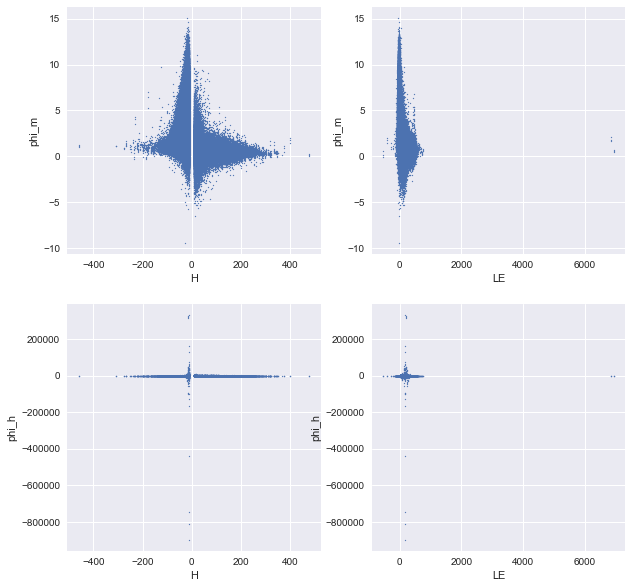

In [200]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1); plt.xlabel('H'); plt.ylabel('phi_m')
plt.scatter(df.H, df.phi_m, s=1)
plt.subplot(2, 2, 2); plt.xlabel('LE'); plt.ylabel('phi_m')
plt.scatter(df.LE, df.phi_m, s=1)
plt.subplot(2, 2, 3); plt.xlabel('H'); plt.ylabel('phi_h')
plt.scatter(df.H, df.phi_h, s=1)
plt.subplot(2, 2, 4); plt.xlabel('LE'); plt.ylabel('phi_h')
plt.scatter(df.LE, df.phi_h, s=1)
plt.show()

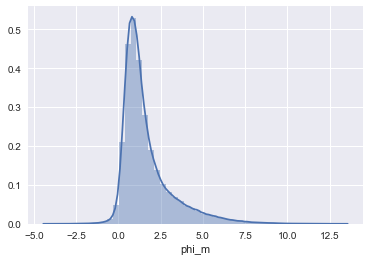

In [52]:
sns.distplot(df.phi_m.dropna())
plt.xlabel('phi_m')
plt.show()

we can compare the CDF of the variables by creating groups based on the range of $\phi_m$. we select the interval (0, 1) because it (supposedly) contains values of phi_m for unstable conditions

In [187]:
ints = [-3, 0, 1, 2, 4, 25]
print('interv.\tcount')
for low, high in zip(ints[:-1], ints[1:]):
    count = len(df[(df.phi_m >= low) & (df.phi_m < high)])
    print('[%d,%d)\t%d' % (low, high, count))

interv.	count
[-3,0)	1662
[0,1)	25286
[1,2)	12276
[2,4)	6406
[4,25)	2881


In [45]:
def plot_cdf(rvars, labels=None, ordinal=False):
    ''' plot the empirical cdf and a boxplot of multple random variables
        in the same chart, to ease comparison

        rvars contains a list of samples for each r.v.
        labels contains a label for each r.v.
    '''
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1]) 
    ax1 = plt.subplot(gs[0])

    if ordinal:
        all_levels = sorted(set(v for var in rvars for v in var))
        level_map = dict(zip(all_levels, range(len(all_levels))))
        inv_level_map = dict(zip(range(len(all_levels)), all_levels))
        rvars = [list(map(level_map.get, var)) for var in rvars]

    for i, values in enumerate(rvars):
        xx = sorted(values)
        yy = np.arange(len(values)) / len(values)
        lbl = labels[i] if labels is not None else None
        
        ax1.plot(xx, yy, label=lbl)

    if labels is not None:
        ax1.legend()

    ax2 = plt.subplot(gs[1])
    sns.boxplot(data=rvars, ax=ax2, orient='h')

    if ordinal:
        ticklb = [
            # ticks are float, get label only on integral ticks
            (inv_level_map.get(int(t), '') if abs(int(t) - t) < 1e-9 else '')
            for t in ax1.get_xticks()
        ]

        ax1.set_xticklabels(ticklb)
        ax2.set_xticklabels(ticklb)

    return ax1, ax2


def inspect_col(colname, partition_by, interval, show=True, fig=None):
    old_pal = sns.color_palette()
    sns.set_palette('GnBu_d')

    vs = [
        df[colname][
            (df[partition_by] >= low) &
            (df[partition_by] < high)
        ].dropna()
        for low, high in zip(interval[:-1], interval[1:])
    ]

    if fig is None:
        fig = plt.figure(figsize=(7, 5))

    ax1, ax2 = plot_cdf(
        vs, list(map(str, zip(interval[:-1], interval[1:]))),
        ordinal=colname in source_cols + ['ds']
    )
    ax1.set_title(colname)
    sns.set_palette(old_pal)
    
    if show:
        plt.show()
    
    return fig, ax1, ax2

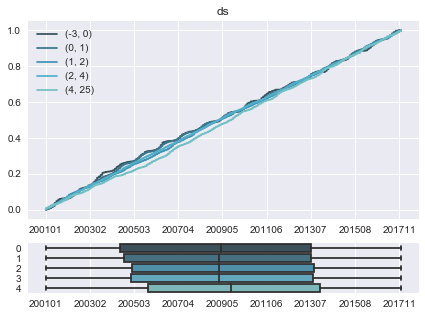

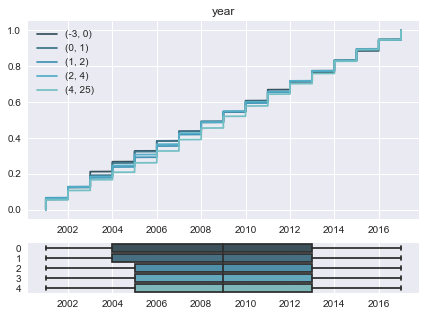

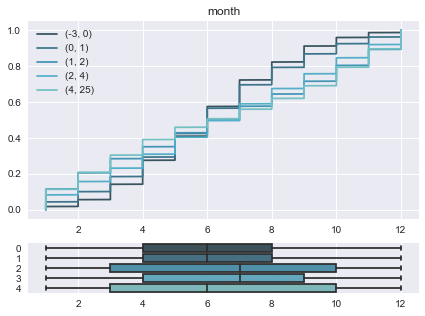

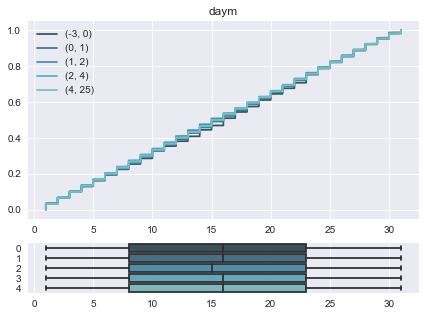

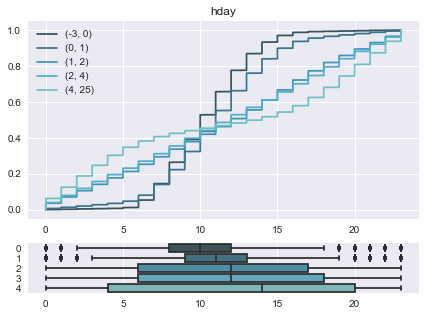

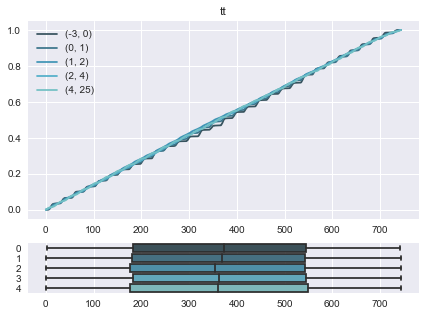

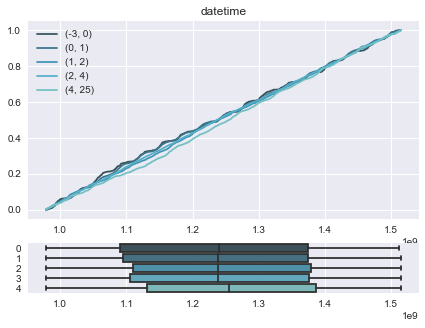

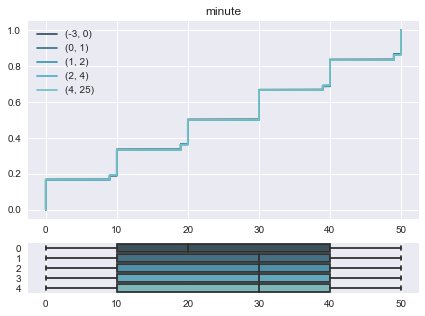

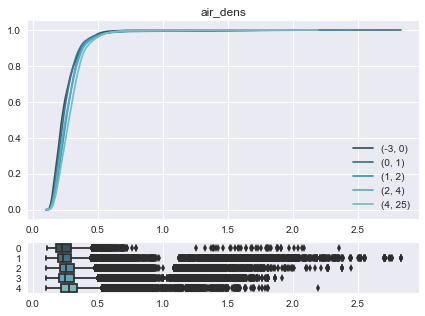

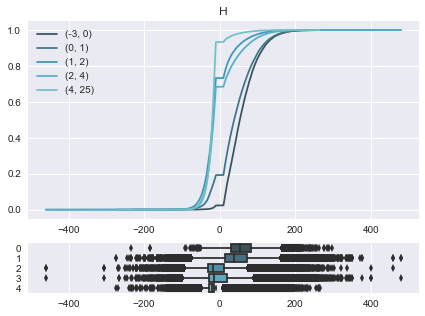

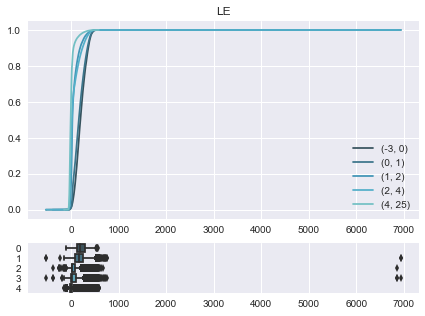

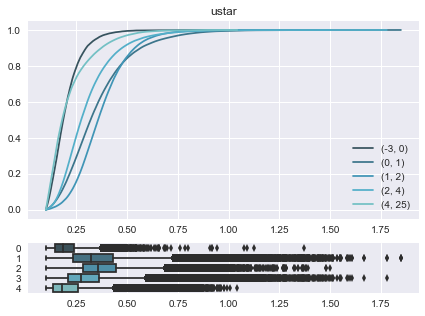

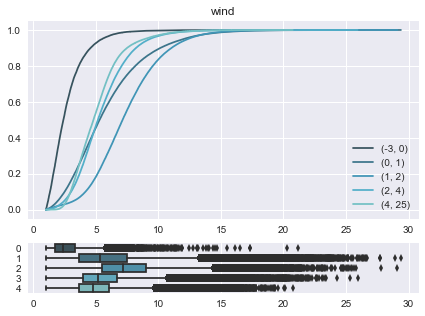

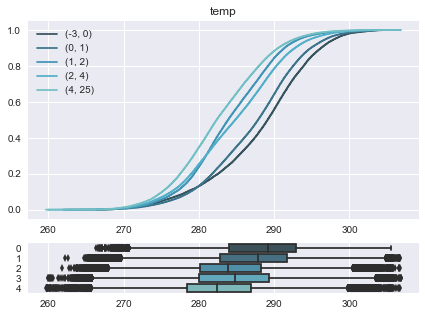

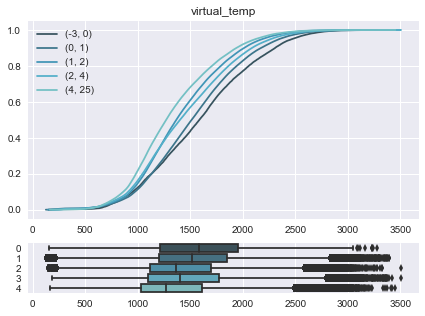

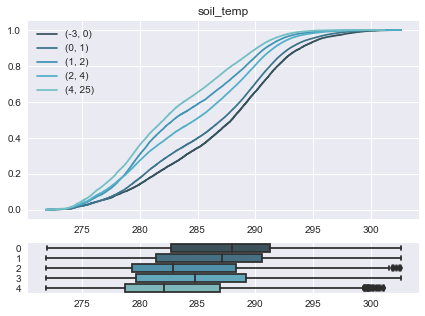

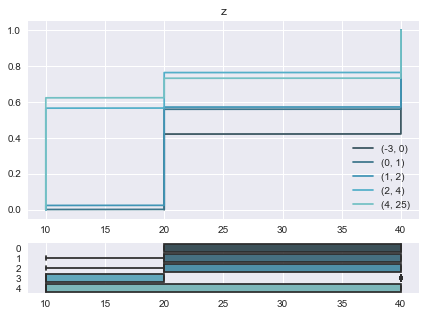

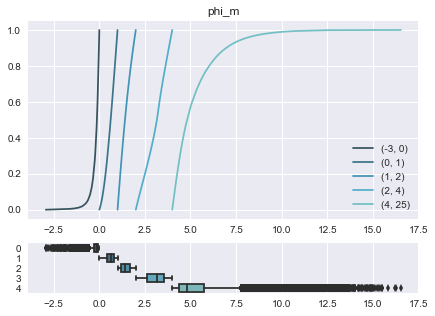

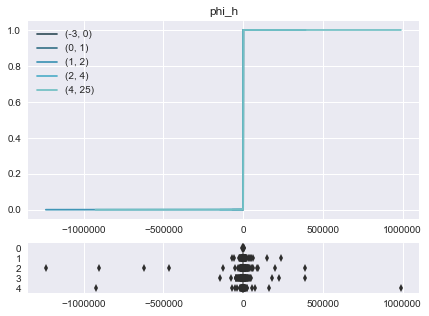

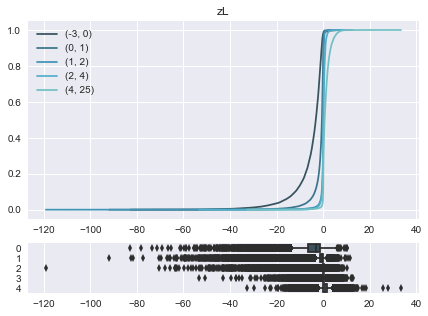

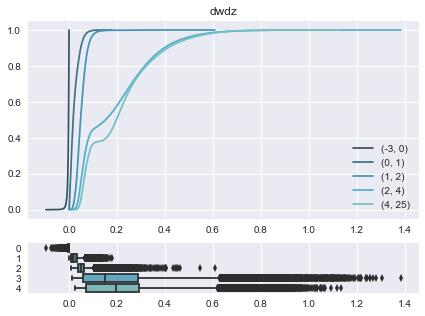

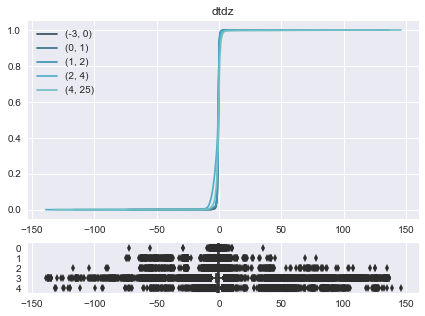

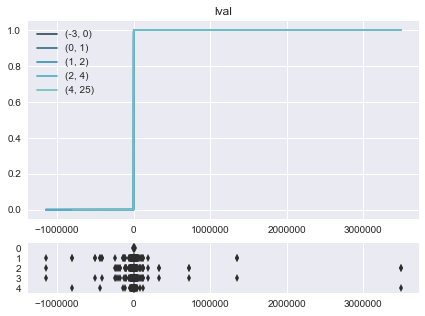

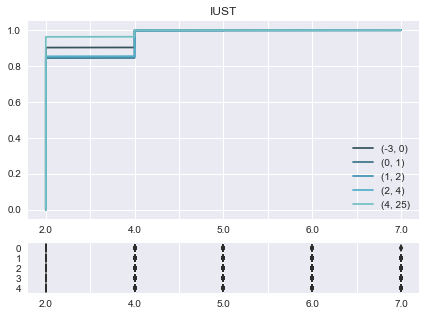

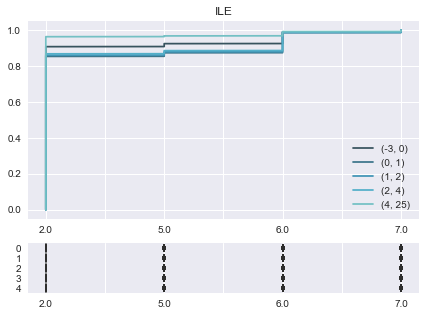

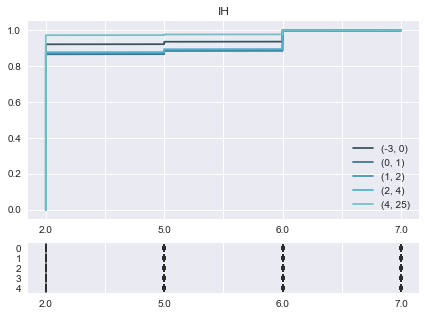

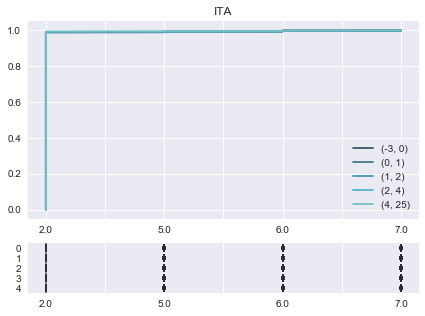

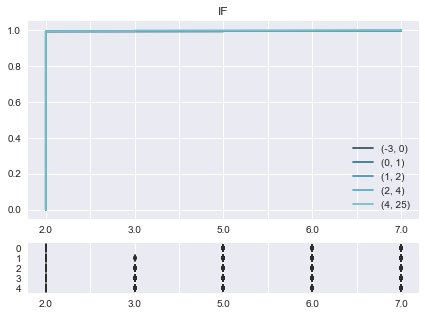

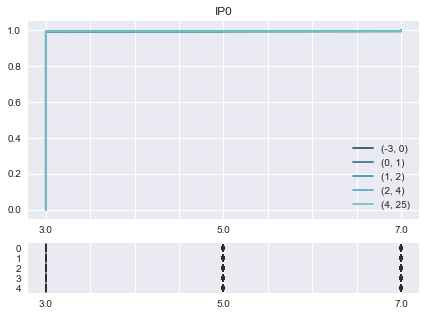

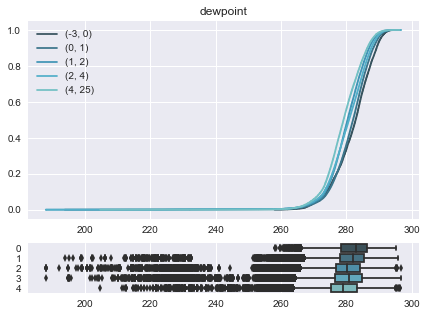

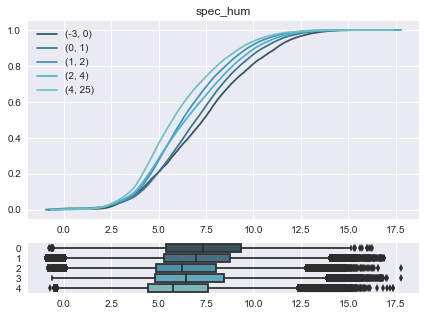

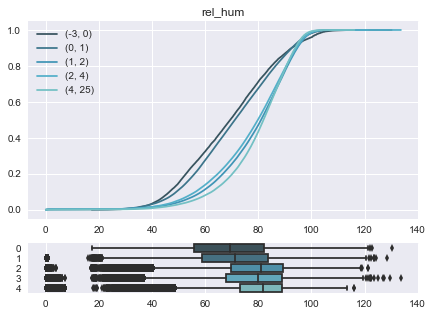

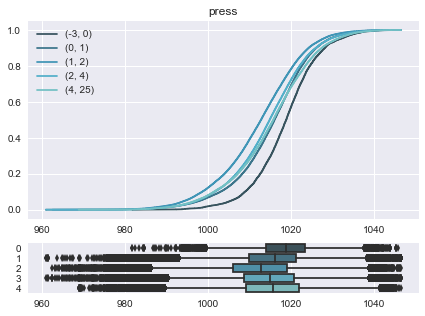

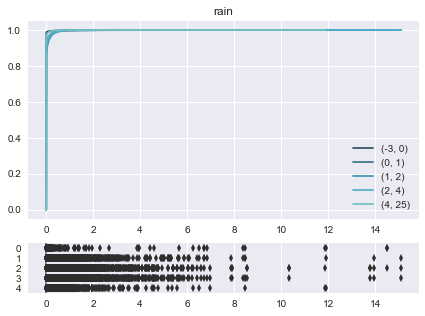

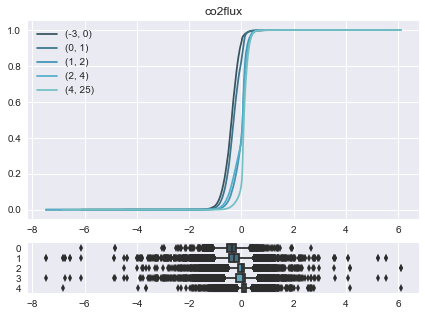

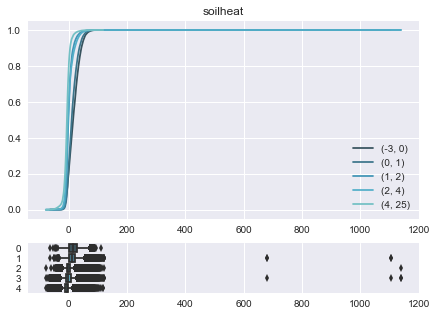

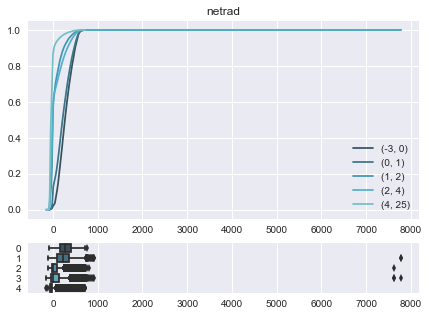

In [32]:
for col in df.columns:
    inspect_col(col, 'phi_m', ints)

seems like the source of the data (I-columns) does not play a big role in differentiating the phi levels

we see larger $\phi_m$s associated with
 - spring
 - night hours
 - denser air
 - colder temperature both soil and air
 - mainly z=10
 - high wind gradient
 - lower heat fluxes and radiation
 - higher relative humidity (both lower specific humidity and dewpoint, the former decreasing faster than the latter)

this is consistent with what we would expect, as $\phi_m$ is expected to be higher in stable condtions

highest $u_*$ in moderately stable conditions, low values in unstable and highly stable conditions; this makes sense, because in unstable conditions most tke comes from eddy fluxes caused by buoyancy, and in very stable conditions we have a calm surface layer with little turbulence. in both cases wind shear does not generate much turbulence

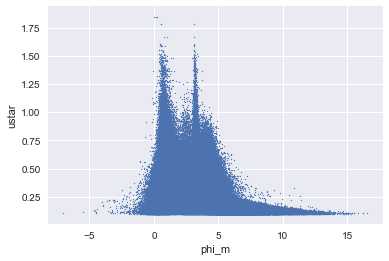

In [33]:
df.plot.scatter('phi_m', 'ustar', s=1)

## inspect z/L

In [223]:
df.zL.describe()

count    1.497010e+06
mean    -7.153704e-02
std      1.968585e+00
min     -1.042494e+02
25%     -2.192331e-01
50%      6.141402e-02
75%      3.524112e-01
max      2.925918e+01
Name: zL, dtype: float64

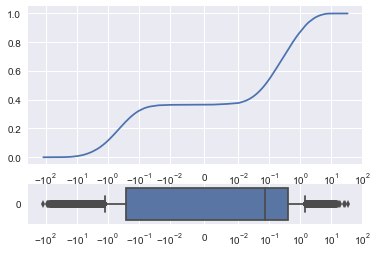

In [36]:
ax1, ax2 = plot_cdf([df.zL], labels=None)
ax1.set_xscale('symlog', linthreshx=1e-2)
ax2.set_xscale('symlog', linthreshx=1e-2)

In [37]:
bins = [
    -120, -1, 0, 1, 50
]

(df.zL.groupby(np.digitize(df.zL, bins))
     .size().rename(lambda b: '[%6.0e, %6.0e)' % (bins[b - 1], bins[b])))

[-1e+02, -1e+00)    176287
[-1e+00,  0e+00)    390887
[ 0e+00,  1e+00)    790586
[ 1e+00,  5e+01)    194660
Name: zL, dtype: int64

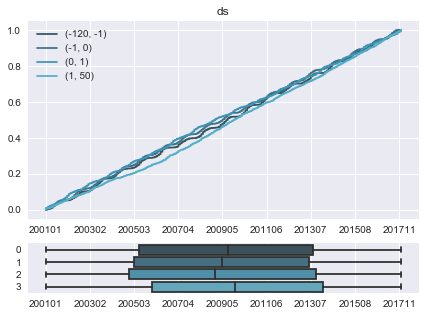

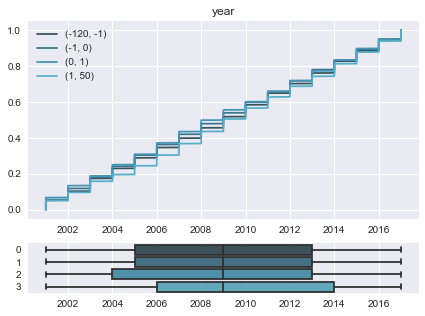

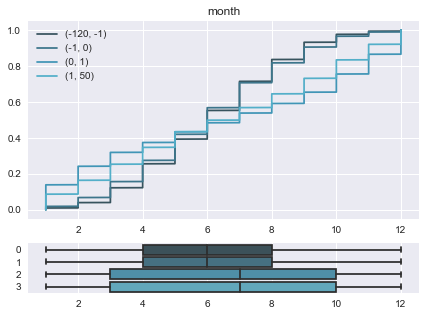

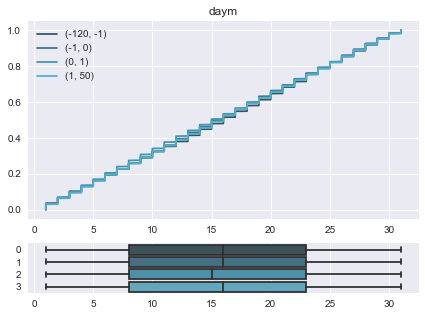

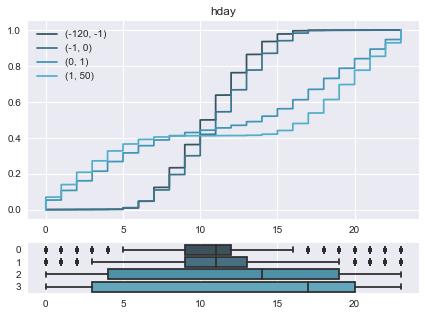

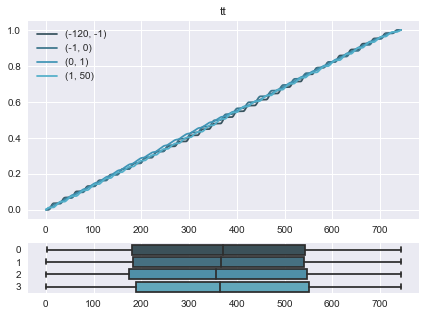

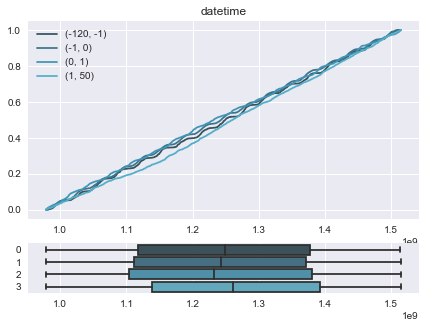

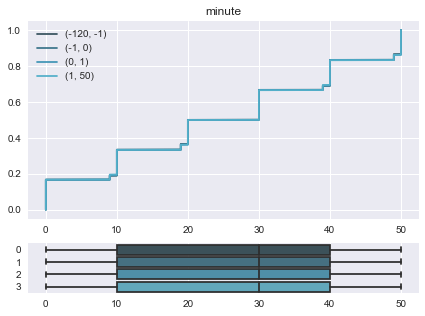

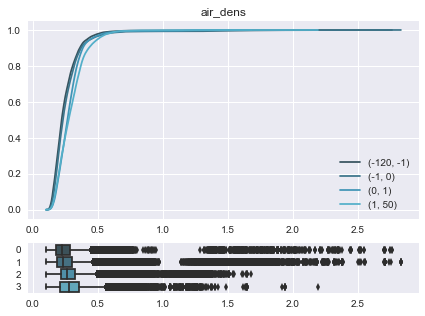

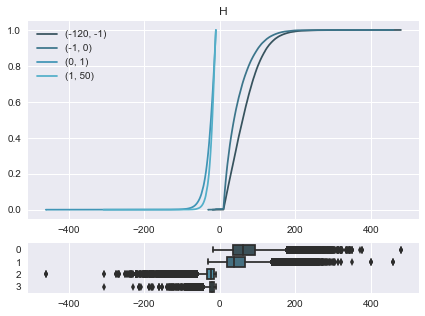

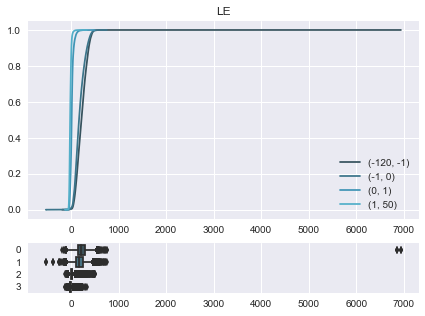

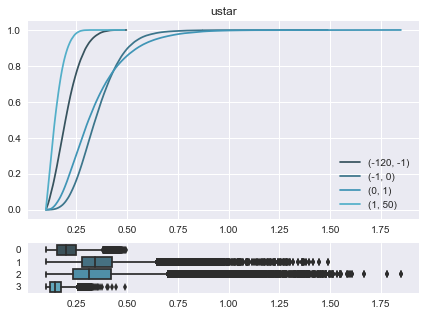

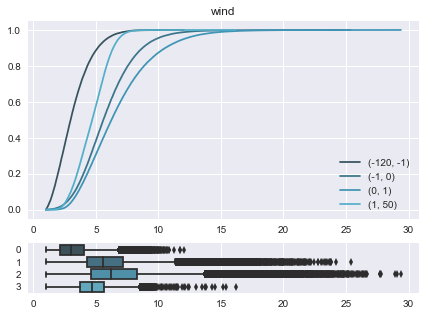

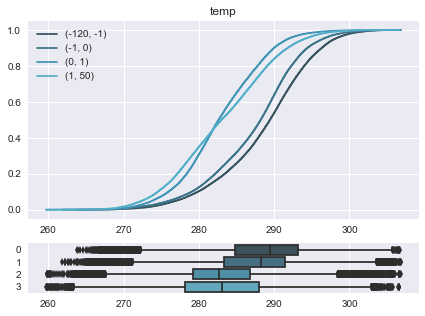

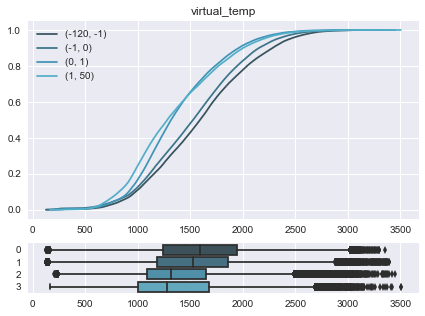

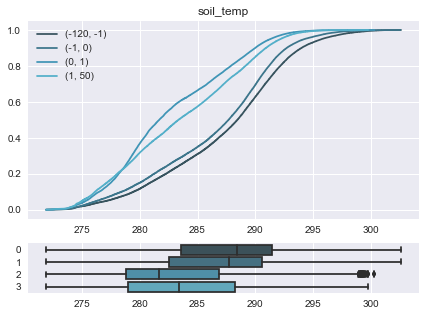

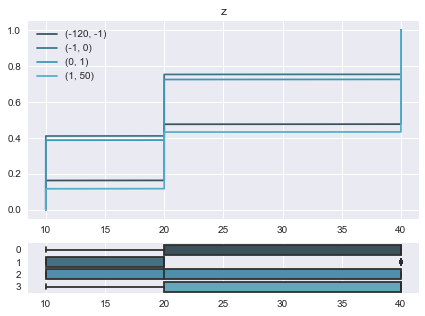

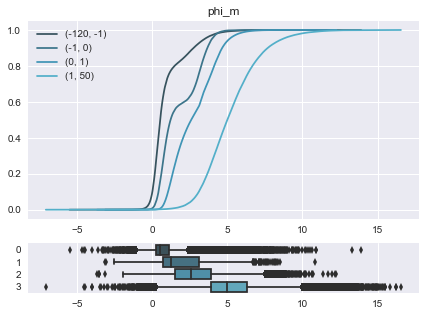

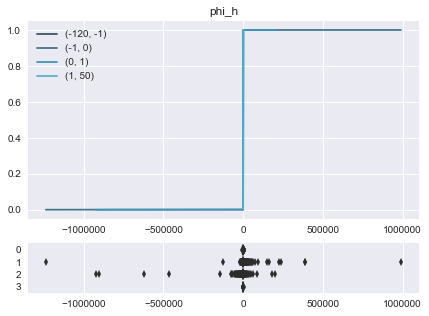

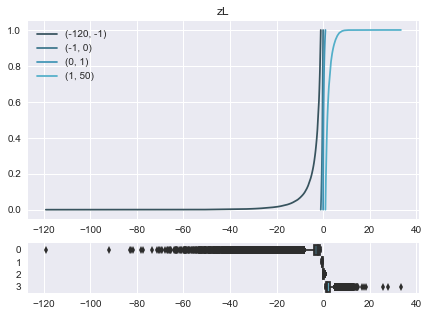

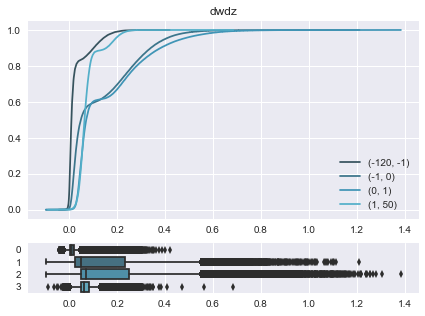

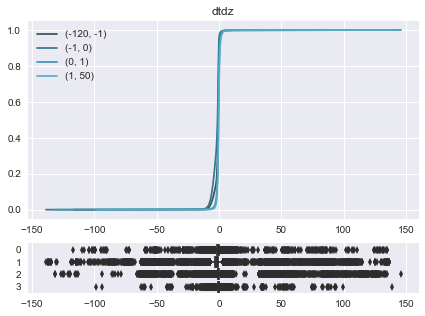

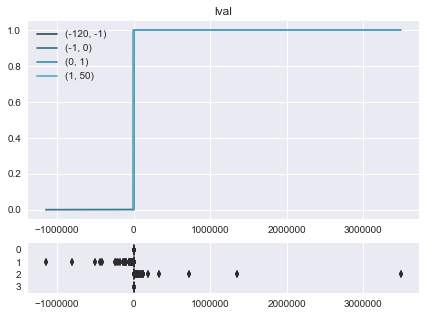

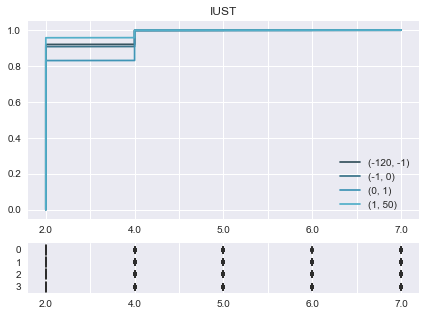

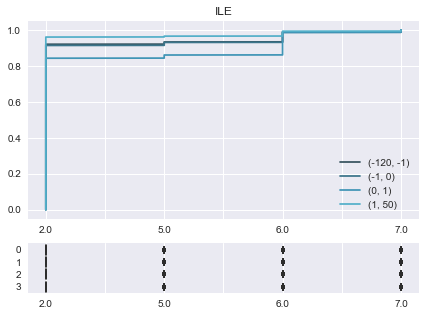

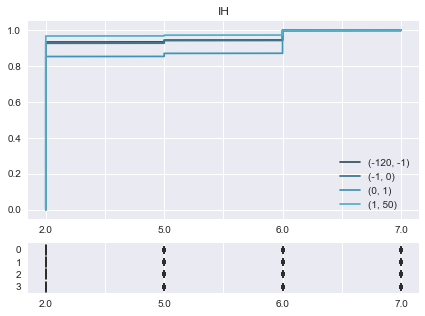

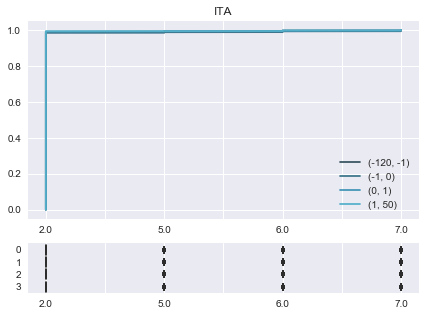

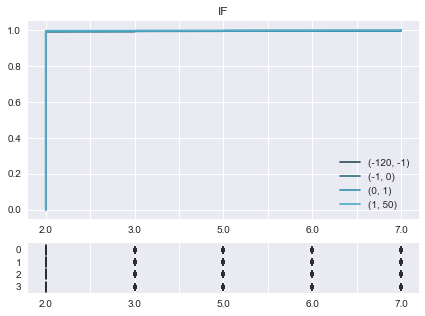

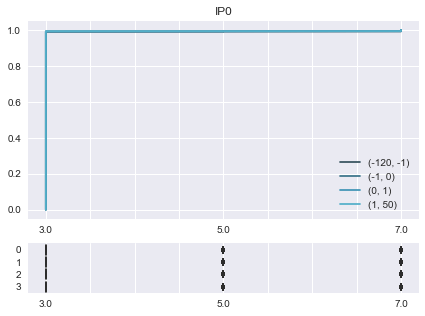

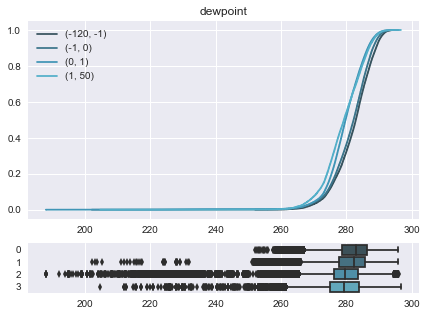

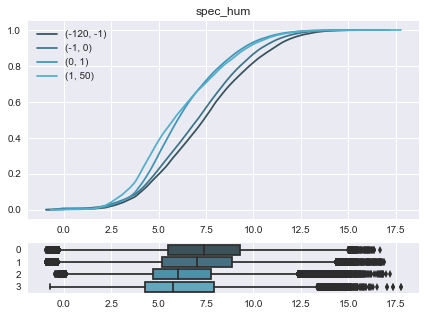

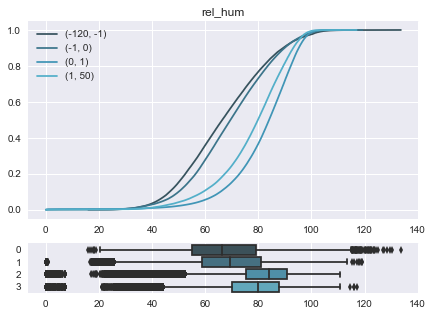

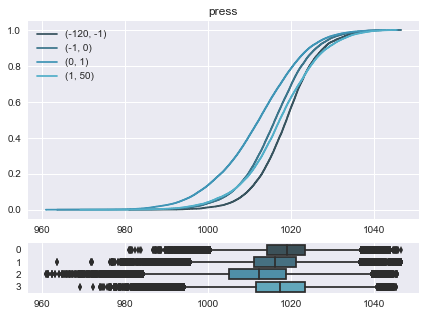

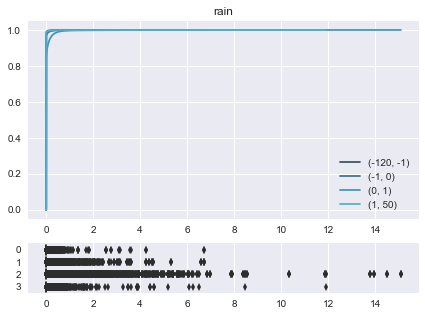

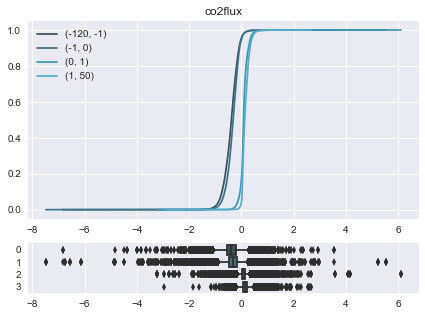

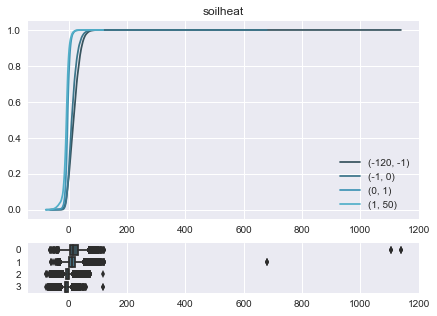

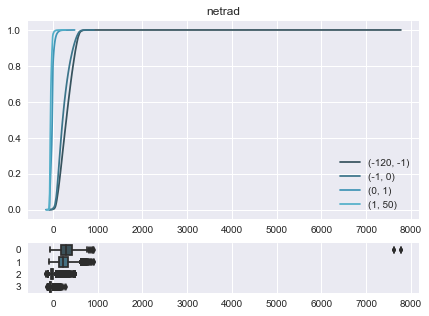

In [38]:
for col in df.columns:
    inspect_col(col, 'zL', bins)

In [39]:
(df.groupby(np.digitize(df.zL, bins))
     [['ustar', 'wind', 'LE', 'temp', 'phi_m']].mean()
     .rename(lambda b: '[%6.0f, %6.0f)' % (bins[b - 1], bins[b])))

ustar      wind          LE        temp     phi_m
[  -120,     -1)  0.206013  3.205570  220.003459  288.704638  0.941135
[    -1,      0)  0.357645  5.864532  181.544207  287.337700  1.826083
[     0,      1)  0.344723  6.728101   12.771379  282.893281  2.774353
[     1,     50)  0.152405  4.703470  -20.926398  283.130343  5.236304

## $\phi_h$

/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


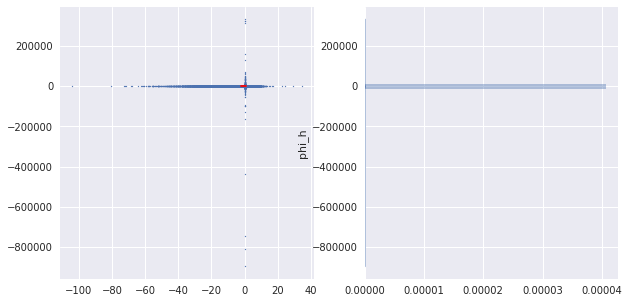

In [59]:
def phi_h(zL):
    if zL < 0:
        return 0.74 * math.pow(1 - 9 * zL, -0.5)
    else:
        return 0.74 + 4.7 * zL

    
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
xx  = np.arange(-2, 1, 0.1)
plt.scatter(df.zL, df.phi_h, s=1)
plt.plot(xx, list(map(phi_h, xx)), 'r')
#plt.xscale('symlog')
#plt.yscale('symlog')
#plt.xlim(-2, 1)

plt.subplot(1, 2, 2)
sns.distplot(df.phi_h.dropna(), vertical=True)
plt.show()

(-5, 30)

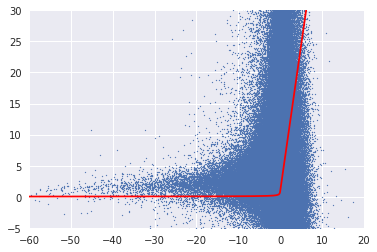

In [60]:
xx = np.arange(-60, 20, 0.1)
plt.scatter(df.zL, df.phi_h, s=1)
plt.plot(xx, list(map(phi_h, xx)), 'r')
plt.xlim(-60, 20)
plt.ylim(-5, 30)

seems wrong

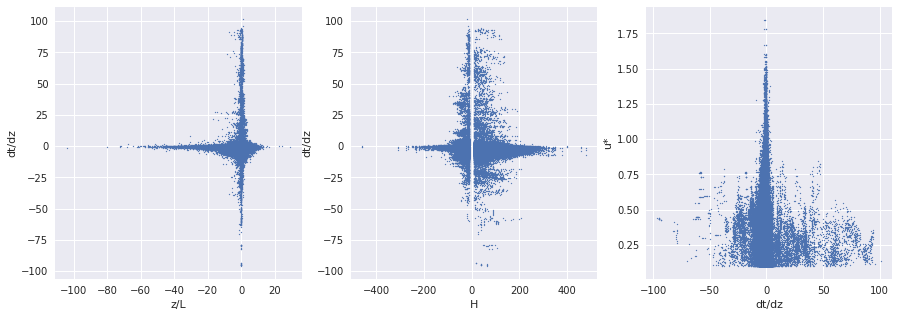

In [269]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(df.zL, df.dtdz, s=1)
plt.xlabel('z/L'); plt.ylabel('dt/dz')
plt.subplot(1, 3, 2)
plt.scatter(df.H, df.dtdz, s=1)
plt.xlabel('H'); plt.ylabel('dt/dz')
plt.subplot(1, 3, 3)
plt.scatter(df.dtdz, df.ustar, s=1)
plt.xlabel('dt/dz'); plt.ylabel('u*')
plt.show()

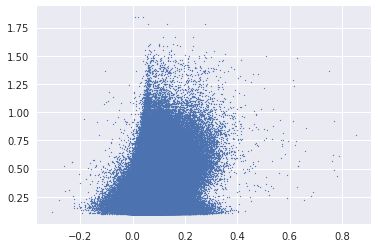

In [270]:
plt.scatter(df.dwdz, df.ustar, s=1)

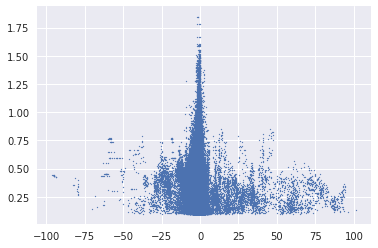

In [271]:
plt.scatter(df.dtdz, df.ustar, s=1)

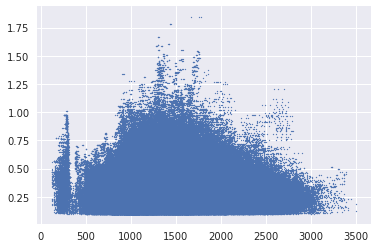

In [272]:
plt.scatter(df.virtual_temp, df.ustar, s=1)

(-250, 1000)

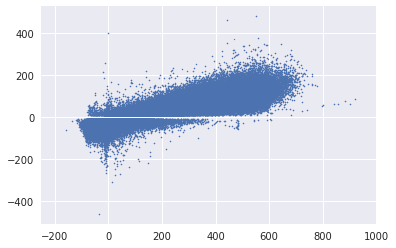

In [275]:
plt.scatter(df.netrad, df.H, s=1)
plt.xlim(-250, 1000)